In [1]:
import pandas as pd
import numpy as np
import json

import seaborn as sn

import requests

from census import Census

from matplotlib import pyplot as plt

import datetime as dt

from config import (gkey,api_key)

from scipy.stats import linregress,pearsonr

from us import states

import gmaps

# Access maps with unique API key
gmaps.configure(api_key=gkey)

#Access census data for 2017
c = Census(api_key, year=2018)


### Loading data into dataframe

In [2]:
#Reading data from source file

accidents_source=pd.read_csv("Accident data/US_Accidents_Dec19.csv")


### Data cleaning

In [3]:
#Checking size of data

accidents_source.size

145742415

In [4]:
accidents_source.shape

(2974335, 49)

In [5]:
#Priniting list of columns in the dataset
accidents_source.columns

Index(['ID', 'Source', 'TMC', 'Severity', 'Start_Time', 'End_Time',
       'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)',
       'Description', 'Number', 'Street', 'Side', 'City', 'County', 'State',
       'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp',
       'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [6]:
#Running to see top 5 records in the dataset

accidents_source.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,...,False,False,False,False,True,False,Day,Day,Day,Day


In [7]:
# Finding total count of values in each column

accidents_source.agg(["count"])

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
count,2974335,2974335,2246264,2974335,2974335,2974335,2974335,2974335,728071,728071,...,2974335,2974335,2974335,2974335,2974335,2974335,2974242,2974242,2974242,2974242


In [8]:
# Finding number of null values within each column

accidents_source.isna().sum()

ID                             0
Source                         0
TMC                       728071
Severity                       0
Start_Time                     0
End_Time                       0
Start_Lat                      0
Start_Lng                      0
End_Lat                  2246264
End_Lng                  2246264
Distance(mi)                   0
Description                    1
Number                   1917605
Street                         0
Side                           0
City                          83
County                         0
State                          0
Zipcode                      880
Country                        0
Timezone                    3163
Airport_Code                5691
Weather_Timestamp          36705
Temperature(F)             56063
Wind_Chill(F)            1852623
Humidity(%)                59173
Pressure(in)               48142
Visibility(mi)             65691
Wind_Direction             45101
Wind_Speed(mph)           440840
Precipitat

In [9]:
accidents_source["Source"].value_counts()


MapQuest         2204098
Bing              728071
MapQuest-Bing      42166
Name: Source, dtype: int64

*The below columns have most of the values as null:</b>

1. End_Lat: 2246264 out of 2974335
2. End_Lng: 2246264 out of 2974335
3. Number: 1917605 out of 2974335
4. Wind_Chill(F): 1852623 out of 2974335
5. Precipitation(in): 1998358 out of 2974335

*The columns <b>End_Lat, End_Lng, Number</b> do not have much significance for our analysis and most of the data is null, the columns will be removed

*Since <b>Wind_Chill(F) and Precipitation(in)</b> are weather factors and might be used in analysis of weather factor relationship with accidents.

*Column <b>"ID"</b> is an identity column for each row and is of no significance in the analysis hence will be removed.

*Column <b>"Source"</b> has three values: MapQuest (2204098), Bing (728071), MapQuest-Bing(42166) with MapQuest being the source for most of the data. Since our focus is not on the source of the data the column will be removed.

*Column <b>"TMC"</b> has been removed as it is needed for our analysis.
*Column <b>"Description"</b> is a brief description of accidents and since other columns provide factors around accidents are provided and sufficient of our analysis, the column is being removed

*Colums related to location of Accidents:

1. Side : Not relevant for our study
2. City: Needed for analysis
3. County: Neede fo analysis
4. State: Needed for analysis
5. Zipcode: Analysis would be based on city, state, county and hence not needed
6. Country: The data is for only for country: US and hence removed
7. Timezone: Since the time of accident is provided in local timezone and being analyzed based on local timezone and hence being removed
8. Airport_Code: Not required in analysis

<b>Amenity, Bump, Crossing, Give_Way, Junction, No_Exit, Railway, Roundabout, Station, Stop, Traffic_Calming, Traffic_Signal, Turning_Loop factors</b> are not being analyzed as part of our study and hence removed from data set

<b>Civil_Twilight, Nautical_Twilight and Astronomical_Twilight </b> are being removed as analysis on time point would be done using Start_Time of accidents

The data provided in the data set is from February 2016 to December 2019 but data before December 2016 will be removed as focus is to analysis data from Winter 2016 to Fall 2019.

In [10]:
#accidents_source[["End Date","End Time"]]=accidents_source["End_Time"].str.split(expand=True)

In [11]:
# Setting list of columns that will used from data source n futher analysis

target_columns=['Severity','Start_Time','End_Time','Start_Lat', 'Start_Lng','City', 'County','State',\
                'Zipcode', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',\
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)','Precipitation(in)', 'Weather_Condition','Sunrise_Sunset']


In [12]:
#Keeping data from December 2016 to reduce size of data and focus on 2017, 2018 and 2019

accident_target=accidents_source.loc[accidents_source['Start_Time']>='2016-12-01'][target_columns].reset_index(drop=True)


In [13]:
accident_target.head()

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,City,County,State,Zipcode,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Sunrise_Sunset
0,2,2016-12-01 00:19:29,2016-12-01 01:04:07,38.481644,-121.334816,Sacramento,Sacramento,CA,95829-9422,37.4,NaN,100.0,30.09,0.8,Calm,NaN,NaN,NaN,Night
1,2,2016-12-01 01:11:30,2016-12-01 01:41:13,37.421124,-122.092476,Mountain View,Santa Clara,CA,94043,46.9,NaN,90.0,30.13,10.0,WSW,3.5,NaN,Clear,Night
2,3,2016-12-01 01:36:51,2016-12-01 02:21:42,37.789349,-122.254303,Oakland,Alameda,CA,94606,46.9,NaN,90.0,30.11,10.0,ESE,5.8,NaN,Mostly Cloudy,Night
3,2,2016-12-01 01:34:28,2016-12-01 02:21:01,37.257954,-122.093964,Saratoga,Santa Clara,CA,95070-9704,48.0,NaN,83.0,30.11,10.0,Calm,NaN,NaN,Clear,Night
4,2,2016-12-01 01:45:02,2016-12-01 02:14:14,38.004459,-122.038872,Concord,Contra Costa,CA,94520,44.1,NaN,82.0,30.07,9.0,Calm,NaN,NaN,Clear,Night


In [14]:
#Checking datatype for columns in the resultant data-set
accident_target.dtypes

Severity               int64
Start_Time            object
End_Time              object
Start_Lat            float64
Start_Lng            float64
City                  object
County                object
State                 object
Zipcode               object
Temperature(F)       float64
Wind_Chill(F)        float64
Humidity(%)          float64
Pressure(in)         float64
Visibility(mi)       float64
Wind_Direction        object
Wind_Speed(mph)      float64
Precipitation(in)    float64
Weather_Condition     object
Sunrise_Sunset        object
dtype: object

In [15]:
# Changing datatype of Start_Time column to datetime as this column will be used to find 
#month/year/season/hour for our time analysis
accident_target["Start_Time"]=pd.to_datetime(accident_target["Start_Time"],format='%Y-%m-%d %H:%M:%S.%f')

In [16]:
# Adding a new column "Start_Year" for analysis on year
accident_target["Start_Year"]=accident_target["Start_Time"].dt.year

#accident_target.head()

In [17]:
#Adding a new column "Season" for analysis based on Season in different years
#Seasons are being set based on below logic:
#months in (Dec,Jan,Feb) then Winter
#months in (Mar,Apr,May) the Spring
#months in (Jun, Jul, Aug) then Summer
#months in (Sep, Oct, Nov) then Fall

accident_target["Season"]=np.select(
    [
        (accident_target["Start_Time"].dt.month== 12) | (accident_target["Start_Time"].dt.month== 1)| (accident_target["Start_Time"].dt.month== 2), 
        (accident_target["Start_Time"].dt.month== 3) | (accident_target["Start_Time"].dt.month== 4)| (accident_target["Start_Time"].dt.month== 5),
        (accident_target["Start_Time"].dt.month== 6) | (accident_target["Start_Time"].dt.month== 7)| (accident_target["Start_Time"].dt.month== 8),
        (accident_target["Start_Time"].dt.month== 9) | (accident_target["Start_Time"].dt.month== 10)| (accident_target["Start_Time"].dt.month== 11)
        
    ], 
    [
        'Winter', 
        'Spring',
        'Summer',
        'Fall'
    ], 
    default='Unknown'
)


In [18]:
accident_target.head()

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,City,County,State,Zipcode,Temperature(F),...,Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Sunrise_Sunset,Start_Year,Season
0,2,2016-12-01 00:19:29,2016-12-01 01:04:07,38.481644,-121.334816,Sacramento,Sacramento,CA,95829-9422,37.4,...,100.0,30.09,0.8,Calm,NaN,NaN,NaN,Night,2016,Winter
1,2,2016-12-01 01:11:30,2016-12-01 01:41:13,37.421124,-122.092476,Mountain View,Santa Clara,CA,94043,46.9,...,90.0,30.13,10.0,WSW,3.5,NaN,Clear,Night,2016,Winter
2,3,2016-12-01 01:36:51,2016-12-01 02:21:42,37.789349,-122.254303,Oakland,Alameda,CA,94606,46.9,...,90.0,30.11,10.0,ESE,5.8,NaN,Mostly Cloudy,Night,2016,Winter
3,2,2016-12-01 01:34:28,2016-12-01 02:21:01,37.257954,-122.093964,Saratoga,Santa Clara,CA,95070-9704,48.0,...,83.0,30.11,10.0,Calm,NaN,NaN,Clear,Night,2016,Winter
4,2,2016-12-01 01:45:02,2016-12-01 02:14:14,38.004459,-122.038872,Concord,Contra Costa,CA,94520,44.1,...,82.0,30.07,9.0,Calm,NaN,NaN,Clear,Night,2016,Winter


In [19]:
#Writing clean data-set into a csv to create smaller and cleaner file that can be used by individual contributors

accident_target.to_csv("TargetData/us_accident_clean.csv",index=False)

# Analysis of Location and Population on Number of Accidents

## Analysis of states based on Number of Accidents

In [20]:
#Creating Dataframe that contains counts of Accidents per state in each year

accident_state_year=pd.DataFrame(accident_target[accident_target["Start_Time"]>='2017-01-01']\
                                 .groupby(["State","Start_Year"])["Start_Time"].count())\
.sort_values("Start_Time",ascending=False).reset_index()

accident_state_year.columns=["State","Year","Accident Count"]

accident_state_year[["State","Year","Accident Count"]].head()


,State,Year,Accident Count
0,CA,2019,213307
1,CA,2018,156777
2,CA,2017,152664
3,TX,2017,85542
4,TX,2018,84049


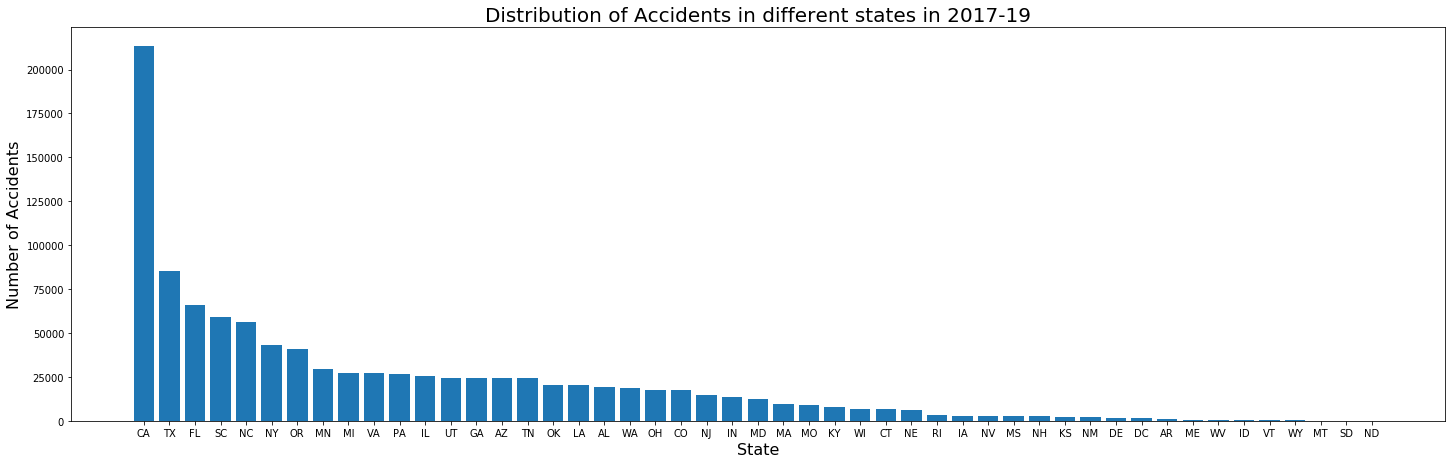

In [21]:
#Plotting of Distribution of Accidents in different states

plt.figure(figsize=(20,6))
_=plt.bar(accident_state_year["State"],accident_state_year["Accident Count"])
plt.tight_layout()

plt.xlabel("State",fontsize=16)

plt.ylabel("Number of Accidents",fontsize=16)

_=plt.title("Distribution of Accidents in different states in 2017-19",fontsize=20)

plt.savefig("Images/Fig1. AccidentsByState.png",bbox_inches='tight')

In [22]:
# calculation combined Month and Year for Start of Accident
accident_target["month_year"]=accident_target["Start_Time"].dt.year.astype(str)\
+'-'+accident_target["Start_Time"].dt.month.astype(str)

In [23]:
#accident_target.groupby("month_year")["Start_Time"].count().nlargest(3).index

In [24]:
#Ceating list of top 3 months of accidents to plot data on maps of number of accidentd

max_accident_3mon=[]
max_accident_3mon.extend(accident_target.groupby("month_year")["Start_Time"].count().nlargest(3).index)

#max_accident_3mon

In [25]:
#CReating a traget dataframe for plotting number of accidents for top 3 months on gmaps
accident_target_max3mon=accident_target.loc[accident_target["month_year"].isin (max_accident_3mon)]

In [26]:
locations=accident_target_max3mon[["Start_Lat","Start_Lng"]]


In [27]:
# PLotting on google maps using gmaps

fig=gmaps.figure()

heatmap_layer=gmaps.heatmap_layer(locations,dissipating=False, max_intensity=5,
                                 point_radius=0.1)


# Add layer
fig.add_layer(heatmap_layer)

# Display figure
fig



Figure(layout=FigureLayout(height='420px'))

##### The distribution of accidents by state show that California is the state with most accidents by almost the double amount of the number of accidents for Texas followed by Florida and New York in suxth position.

### 10 Cities with largest number of accidents in 2017-2019

In [28]:
# Create a datafram of top 10 cities with maximum number of accidents in 2017-2019

cities_accidents=accident_target.groupby(["City"])["Start_Time"].count().nlargest(10).reset_index()
#locations_ca_ny.head()

cities_accidents.columns=["City","Accident Count"]

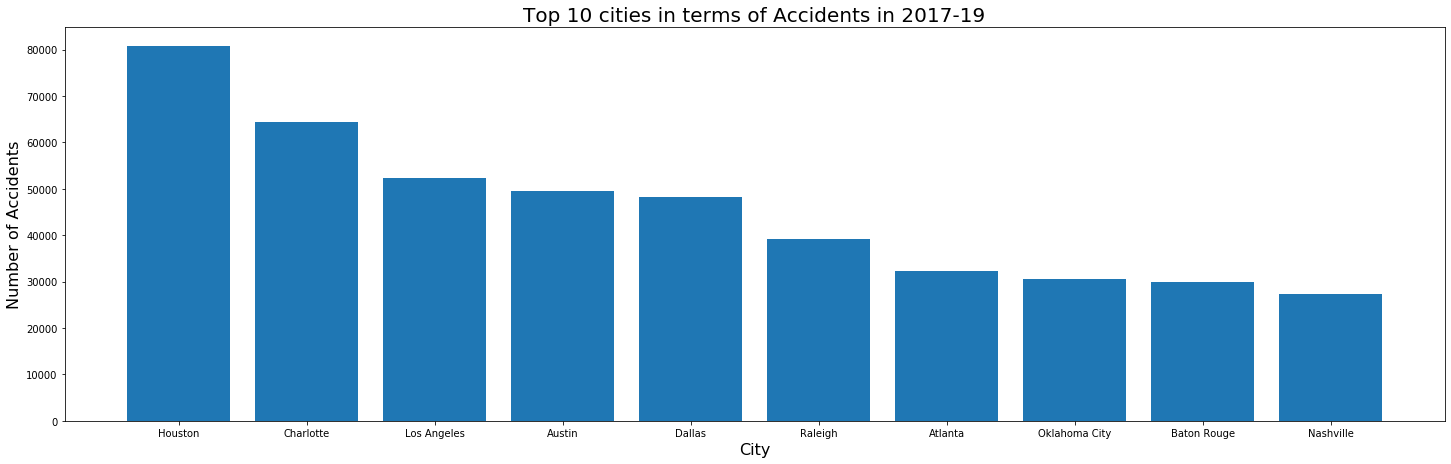

In [29]:
#Ploting 10 Cities vs Accidents
plt.figure(figsize=(20,6))
_=plt.bar(cities_accidents["City"],cities_accidents["Accident Count"])
plt.tight_layout()

plt.xlabel("City",fontsize=16)

plt.ylabel("Number of Accidents",fontsize=16)

_=plt.title("Top 10 cities in terms of Accidents in 2017-19",fontsize=20)

plt.savefig("Images/Fig2.TopCities_Accident.png", bbox_inches='tight')

##### Though California is the state with most accidents (almost triple than next state with most accidents) but ony one city in California (Los Angeles) is among 10 cities with most accidents

Let's see the distribution of accidents in different cities of California and Texas

In [30]:
accidents_cities_CA_TX=accident_target[accident_target["State"].isin(["CA","TX"])]\
                                    .groupby(["State","City"])["Start_Time"].count().reset_index()
accidents_cities_CA_TX.rename(columns={"Start_Time":"Accident Count"},inplace=True)


In [31]:
accidents_cities_CA_TX.sort_values(["Accident Count"],ascending=False)

,State,City,Accident Count
1439,TX,Houston,80710
569,CA,Los Angeles,52363
1177,TX,Austin,49287
1302,TX,Dallas,47933
874,CA,Sacramento,20290
...,...,...,...
1345,TX,Eola,1
1560,TX,McLean,1
1346,TX,Etoile,1
1694,TX,Saint Hedwig,1


In [32]:
#plt.bar(accidents_cities_CA_TX["City"],accidents_cities_CA_TX["Accident Count"])

### Analysis of accidents with Years and Severity

In [33]:
# Extract years of interest and get number of accidents for each year
target_years = accident_target[(accident_target["Start_Year"] >= 2017) & (accident_target["Start_Year"] < 2020)]
yearly_accidents = target_years.groupby("Start_Year")
yearly_counts = yearly_accidents["Start_Year"].count()
yearly_counts

Start_Year
2017    717483
2018    892615
2019    953630
Name: Start_Year, dtype: int64

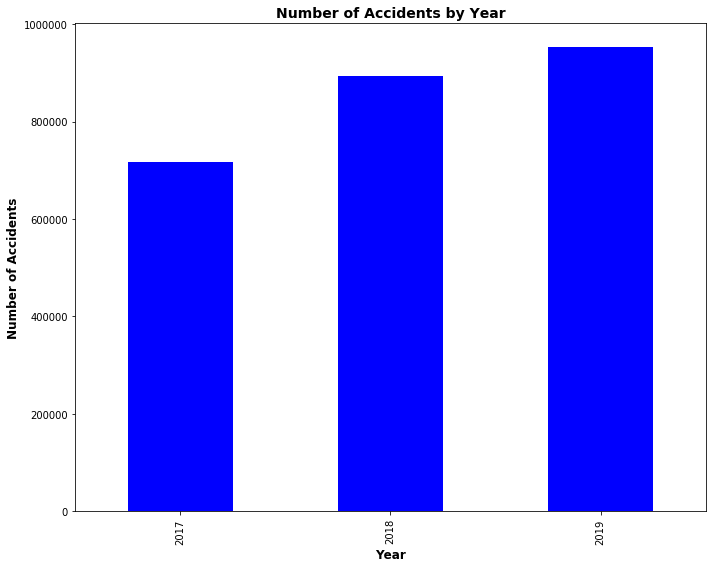

In [34]:
# Plot the number of accidents by year
accident_count = yearly_counts.plot(kind="bar", color="blue", figsize=(10,8))
plt.title("Number of Accidents by Year", fontweight="bold", fontsize=14)
plt.xlabel("Year", fontweight='bold', fontsize=12)
plt.ylabel("Number of Accidents", fontweight='bold', fontsize=12)

# Save image and show graph
plt.savefig("Images/Fig3. AccidentsByYear.png")
plt.tight_layout()
plt.show();

##### Number of accidents seems to show a steady increase each year from 2017 to 2019.

In [35]:
# Get severity counts by year
severity_counts = yearly_accidents["Severity"].value_counts()
severity_counts = severity_counts.to_frame()
severity_by_year = severity_counts.rename(columns= {severity_counts.columns[0]: "Severity Count"})
severity_by_year.reset_index(inplace=True)
severity_by_year

,Start_Year,Severity,Severity Count
0,2017,2,461971
1,2017,3,231081
2,2017,4,24149
3,2017,1,282
4,2018,2,574016
5,2018,3,292570
6,2018,4,25770
7,2018,1,259
8,2019,2,687573
9,2019,3,237790


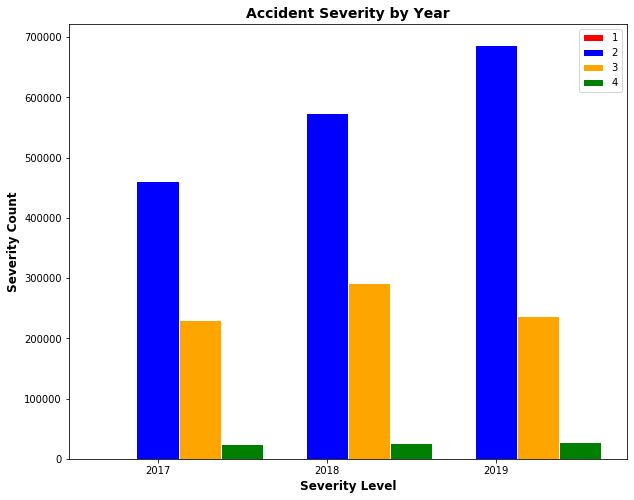

In [36]:
# Create plot to compare accident severity levels by year
plt.figure(figsize=(10, 8))
barWidth = 0.25

# Set height of bar
y1 = severity_by_year[severity_by_year["Severity"]==1]["Severity Count"].to_list()
y2 = severity_by_year[severity_by_year["Severity"]==2]["Severity Count"].to_list()
y3 = severity_by_year[severity_by_year["Severity"]==3]["Severity Count"].to_list()
y4 = severity_by_year[severity_by_year["Severity"]==4]["Severity Count"].to_list()

# Set position of bar on X axis
x1 = np.arange(len(y1))
x2 = [x + barWidth for x in x1]
x3 = [x + barWidth for x in x2]
x4 = [x + barWidth for x in x3]
 
# Make the plot
plt.bar(x1, y1, color="r", width=barWidth, edgecolor="white", label="1")
plt.bar(x2, y2, color="b", width=barWidth, edgecolor="white", label="2")
plt.bar(x3, y3, color="orange", width=barWidth, edgecolor="white", label="3")
plt.bar(x4, y4, color="g", width=barWidth, edgecolor="white", label="4")
 
# Add xticks and lables
plt.title("Accident Severity by Year", fontweight="bold", fontsize=14)
plt.xlabel("Severity Level", fontweight="bold", fontsize=12)
plt.ylabel("Severity Count", fontweight="bold", fontsize=12)
plt.xticks([r + barWidth for r in range(len(y1))], ["2017", "2018", "2019"])
 
# Create legend, save image and show graph
plt.legend()
plt.savefig("Images/Fig4. SeverityByYear.png")
plt.show();


##### Severity of accidents by year. The graph shows that the level of severity of 2 is the most frequent, followed by 3 with 1 and 4 being very minimal by comparison. Severity level in this case is as follows: 1 indicates the least impact on traffic (i.e., short delay) and 4 indicates major impact on traffic (i.e. long delay)

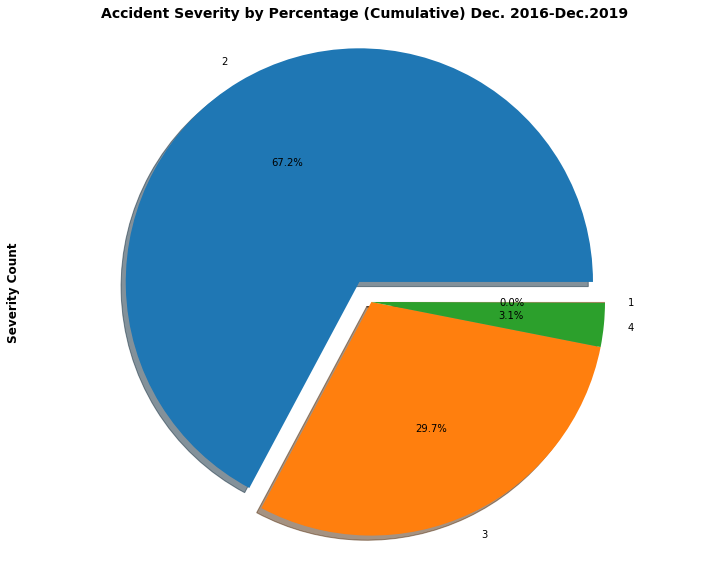

In [37]:
# Create a pie chart to showcase the percentage of each severity 
plt.figure(figsize=(10, 8))
accident_target["Severity"].value_counts().plot.pie(explode=[0.1,0,0,0],autopct="%1.1f%%",shadow=True)
plt.title("Accident Severity by Percentage (Cumulative) Dec. 2016-Dec.2019", fontweight="bold", fontsize=14)
plt.ylabel("Severity Count",fontweight="bold", fontsize=12)
plt.axis("equal")

# Save image and show graph
plt.savefig("Images/Fig5. TotalSeverity.png")
plt.tight_layout()
plt.show()

##### Chart showing the cumulative percentage of accidents based on severity level. This again shows that most accidents cause medium and moderate delay in traffic accounts for approx. 97% of all accidents between December 2016 to December 2019.

## Relationship of accidents with population density in different states

In [38]:
# Finding population and other census data using census api for all states in USA

census_state = c.acs5.state(("NAME", "B19013_001E", "B01003_001E", "B01002_001E",
                          "B19301_001E",
                          "B17001_002E",
                          "B23025_005E"), Census.ALL)

In [39]:
# Creating dataframe of census and renaming column

census_state_df=pd.DataFrame(census_state)

census_state_df.rename(columns={"NAME":"State",
                                "B01003_001E": "Population",
                                "B01002_001E": "Median Age",
                                "B19013_001E": "Household Income",
                                "B19301_001E": "Per Capita Income",
                                "B17001_002E": "Poverty Count",
                                "B23025_005E": "Unemployment Count"}, inplace=True)

census_state_df.head()

,State,Household Income,Population,Median Age,Per Capita Income,Poverty Count,Unemployment Count,state
0,Minnesota,68411.0,5527358.0,37.9,36245.0,547442.0,119218.0,27
1,Mississippi,43567.0,2988762.0,37.2,23434.0,599795.0,110036.0,28
2,Missouri,53560.0,6090062.0,38.5,29537.0,837930.0,155958.0,29
3,Montana,52559.0,1041732.0,39.8,29765.0,139063.0,22433.0,30
4,Nebraska,59116.0,1904760.0,36.4,31101.0,213790.0,36545.0,31


In [40]:
# We have states name in census data but abbreviation in accident dataset.. 
#Importing an excel for mapping of abbreviation and name into a dataframe
accident_state_abbrev=pd.read_excel("state_abbrev.xlsx")

In [41]:
accident_state_abbrev.head()

,State,Abbreviation
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA


In [42]:
#Creating datframe for accident count by state

accident_states=pd.DataFrame(accident_target.groupby(["State"])["Start_Time"].count().reset_index())
accident_states.columns=["State","Accident Count"]

In [43]:
accident_states.head()

,State,Accident Count
0,AL,36258
1,AR,1726
2,AZ,59989
3,CA,537673
4,CO,38999


In [44]:
# Creating dataframe for accident count per state with names of state added from state abbreviation dataframe

accident_states_df=accident_states.merge(accident_state_abbrev,left_on="State",right_on="Abbreviation").drop("State_x",axis=1)
#["State_y","Abbreviation","Accident Count"]
accident_states_df.rename(columns={"State_y":"State"},inplace=True)

#accident_states_df.head()

In [45]:
#Creating a dataframe containing census and accident count for each state

accident_states_population=accident_states_df.merge(census_state_df,on="State")

accident_states_population["Population(mil)"]=accident_states_population["Population"]/1000000

accident_states_population.head()

,Accident Count,State,Abbreviation,Household Income,Population,Median Age,Per Capita Income,Poverty Count,Unemployment Count,state,Population(mil)
0,36258,Alabama,AL,48486.0,4864680.0,38.9,26846.0,829400.0,147898.0,01,4.864680
1,1726,Arkansas,AR,45726.0,2990671.0,37.9,25635.0,510337.0,75774.0,05,2.990671
2,59989,Arizona,AZ,56213.0,6946685.0,37.4,29265.0,1092192.0,210214.0,04,6.946685
3,537673,California,CA,71228.0,39148760.0,36.3,35021.0,5487141.0,1321502.0,06,39.148760
4,38999,Colorado,CO,68811.0,5531141.0,36.6,36415.0,590504.0,139326.0,08,5.531141


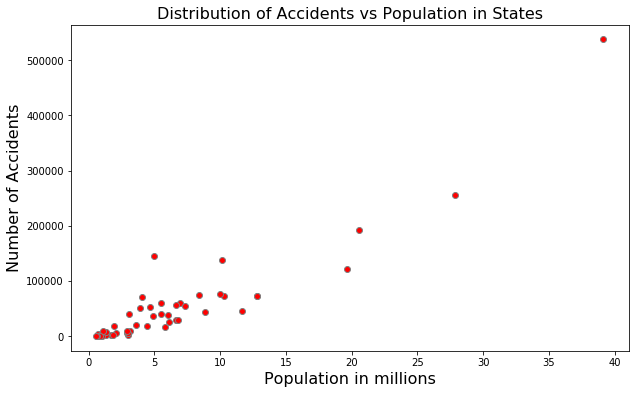

In [46]:
# Plotting Distribution of Accidents vs Population in States

x_axis=accident_states_population["Population(mil)"]
y_axis=accident_states_population["Accident Count"]

plt.figure(figsize=(10,6))
plt.scatter(x_axis,y_axis,facecolor="red",edgecolor="grey")

plt.title("Distribution of Accidents vs Population in States",fontsize=16)
plt.xlabel("Population in millions",fontsize=16)
_=plt.ylabel("Number of Accidents",fontsize=16)

plt.savefig("Images/Fig6. Accident_Population_State")

##### It can be inferred from the graph that state with more population witness more accidents

### Distribution of number of accidents against population in counties of California

In [47]:
# Finding population and other census data using census api for all states and counties in USA

census_state_county=c.acs5.state_county(("NAME", "B19013_001E", "B01003_001E", "B01002_001E",
                          "B19301_001E",
                          "B17001_002E",
                          "B23025_005E"), Census.ALL, Census.ALL)


In [48]:
#Creating dataframe for census data using census api for all states and counties in USA
#County and State name is combined in one column Name
#Using split function to split data into two columns in dataframe

census_state_county_df=pd.DataFrame(census_state_county)

census_state_county_df[["County","State"]]=census_state_county_df["NAME"].str.split(', ',expand=True)

census_state_county_df.rename(columns={"B01003_001E": "Population",
                                "B01002_001E": "Median Age",
                                "B19013_001E": "Household Income",
                                "B19301_001E": "Per Capita Income",
                                "B17001_002E": "Poverty Count",
                                "B23025_005E": "Unemployment Count"}, inplace=True)

census_state_county_df.head()

,NAME,Household Income,Population,Median Age,Per Capita Income,Poverty Count,Unemployment Count,state,county,County,State
0,"Washington County, Mississippi",30834.0,47086.0,36.9,19884.0,15496.0,3041.0,28,151,Washington County,Mississippi
1,"Perry County, Mississippi",39007.0,12028.0,40.9,21611.0,2231.0,337.0,28,111,Perry County,Mississippi
2,"Choctaw County, Mississippi",37203.0,8321.0,44.0,20589.0,1888.0,301.0,28,019,Choctaw County,Mississippi
3,"Itawamba County, Mississippi",40510.0,23480.0,40.0,20629.0,3428.0,414.0,28,057,Itawamba County,Mississippi
4,"Carroll County, Mississippi",43060.0,10129.0,47.0,22567.0,1477.0,377.0,28,015,Carroll County,Mississippi


In [49]:
# CReating dataframe to get census data only for california
# Since County name contains County in Census data but not in Accidents data; remove text ' county' from county name in census data

census_ca_county_df=census_state_county_df[census_state_county_df["State"]=="California"]

#census_state_county_df[census_state_county_df.county.str.endswith('County')]
census_ca_county_df["County"].str.replace(' County','')

census_ca_county_df["County"]=census_ca_county_df["County"].str.replace(' County','')

census_ca_county_df.head()

#census_ca_county_df["County"].unique()

C:\Users\lilia\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,NAME,Household Income,Population,Median Age,Per Capita Income,Poverty Count,Unemployment Count,state,county,County,State
1854,"Lake County, California",42475.0,64148.0,45.6,25404.0,13224.0,2556.0,06,033,Lake,California
1855,"Mariposa County, California",51199.0,17540.0,51.4,29776.0,2435.0,676.0,06,043,Mariposa,California
1856,"Yuba County, California",52624.0,75493.0,32.5,23867.0,13298.0,2648.0,06,115,Yuba,California
1857,"Contra Costa County, California",93712.0,1133247.0,39.4,45524.0,102543.0,35563.0,06,013,Contra Costa,California
1858,"Lassen County, California",56362.0,31185.0,36.0,21897.0,2933.0,570.0,06,035,Lassen,California


In [50]:
#Create dataframe for acident by state and city

accident_states_county=pd.DataFrame(accident_target.groupby(["State","County"])["Start_Time"].count().reset_index())
accident_states_county.columns=["State","County","Accident Count"]

In [51]:
# mErge with State Abbreviation and name dataframe to add state name in the column

accident_states_county_df=accident_states_county.merge(accident_state_abbrev,left_on="State",right_on="Abbreviation").drop("State_x",axis=1)
#["State_y","Abbreviation","Accident Count"]
accident_states_county_df.rename(columns={"State_y":"State"},inplace=True)

accident_states_county_df.head()

,County,Accident Count,State,Abbreviation
0,Autauga,307,Alabama,AL
1,Baldwin,998,Alabama,AL
2,Barbour,39,Alabama,AL
3,Bibb,49,Alabama,AL
4,Blount,1156,Alabama,AL


In [52]:
#Create dataframe with accident data for california county along with census data
accident_county_population_ca=accident_states_county_df.merge(census_ca_county_df,on=["State","County"])

accident_county_population_ca["Population(tenthou)"]=accident_county_population_ca["Population"]/10000

accident_county_population_ca.head()

,County,Accident Count,State,Abbreviation,NAME,Household Income,Population,Median Age,Per Capita Income,Poverty Count,Unemployment Count,state,county,Population(tenthou)
0,Alameda,36705,California,CA,"Alameda County, California",92574.0,1643700.0,37.4,44283.0,170884.0,45110.0,06,001,164.3700
1,Alpine,54,California,CA,"Alpine County, California",64688.0,1146.0,44.3,29041.0,227.0,79.0,06,003,0.1146
2,Amador,606,California,CA,"Amador County, California",61198.0,37829.0,50.5,30100.0,3323.0,1255.0,06,005,3.7829
3,Butte,1363,California,CA,"Butte County, California",48443.0,227075.0,37.1,27537.0,44410.0,9085.0,06,007,22.7075
4,Calaveras,733,California,CA,"Calaveras County, California",58151.0,45235.0,52.1,32494.0,5242.0,1116.0,06,009,4.5235


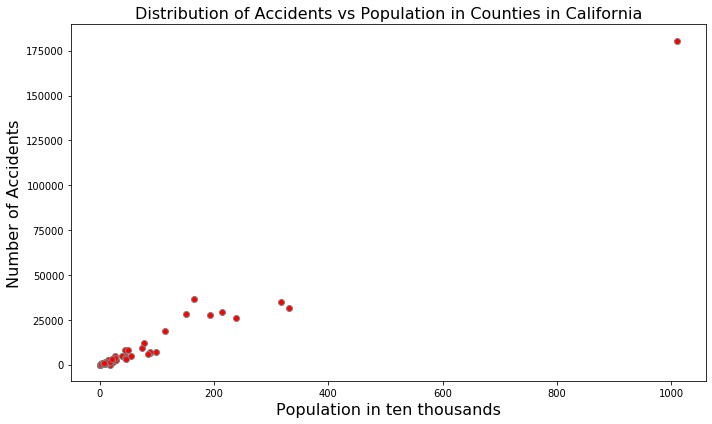

In [53]:
#Plotting distribution of accidents vs population in counties in california

x_axis=accident_county_population_ca["Population(tenthou)"]
y_axis=accident_county_population_ca["Accident Count"]

plt.figure(figsize=(10,6))
plt.scatter(x_axis,y_axis,facecolor="red",edgecolor="grey")

plt.title("Distribution of Accidents vs Population in Counties in California",fontsize=16)
plt.xlabel("Population in ten thousands",fontsize=16)
_=plt.ylabel("Number of Accidents",fontsize=16)

plt.savefig("Images/Fig7. Accident_Population_County_CA")

plt.tight_layout()
#for i, text in enumerate(accident_county_population_ca.loc[accident_county_population_ca["Accident Count"]>25000,"County"]):
#   plt.annotate(text,(x_axis[i],y_axis[i]))

In [54]:
#Top 10 counties in terms of Accident Count

accident_county_population_ca[["County","Population","Accident Count"]].sort_values("Accident Count",ascending=False).head(10)

,County,Population,Accident Count
18,Los Angeles,10098052.0,180604
0,Alameda,1643700.0,36705
29,Orange,3164182.0,34719
36,San Diego,3302833.0,31635
35,San Bernardino,2135413.0,29582
33,Sacramento,1510023.0,28209
42,Santa Clara,1922200.0,27521
32,Riverside,2383286.0,26264
6,Contra Costa,1133247.0,18877
40,San Mateo,765935.0,12312


##### It is very evident from the graph that Los Angeles is worst affected county in california in terms of number of accidents and one of the factor reponsible for that is due to very large population in Los Angeles compared to other counties in California and has skewed the number of accidents in California compared to other states.

# Time Analysis

In [55]:
accident_target.count()

Severity             2623302
Start_Time           2623302
End_Time             2623302
Start_Lat            2623302
Start_Lng            2623302
City                 2623244
County               2623302
State                2623302
Zipcode              2622516
Temperature(F)       2572734
Wind_Chill(F)        1104925
Humidity(%)          2570090
Pressure(in)         2579648
Visibility(mi)       2564745
Wind_Direction       2581129
Wind_Speed(mph)      2248405
Precipitation(in)     947119
Weather_Condition    2564660
Sunrise_Sunset       2623235
Start_Year           2623302
Season               2623302
month_year           2623302
dtype: int64

### Analyze accidents across seasons

In [56]:
#Combining season and year into one column

accident_target["Season_Year"]=np.select(
    [
        (accident_target["Start_Time"].dt.month== 1)| (accident_target["Start_Time"].dt.month== 2) 
    ], 
    [
       (accident_target["Start_Year"]-1).astype(str)+'-'+accident_target["Season"]
    ], 
    default=accident_target["Start_Year"].astype(str)+'-'+accident_target["Season"]
)


In [57]:
accident_target["Season_Year"].unique()

array(['2016-Winter', '2017-Spring', '2017-Summer', '2019-Winter',
       '2019-Fall', '2019-Summer', '2019-Spring', '2018-Winter',
       '2018-Fall', '2018-Summer', '2018-Spring', '2017-Winter',
       '2017-Fall'], dtype=object)

In [58]:
# Removing Winter-2019 as ther is only one month for Winter -2019

accident_target.loc[accident_target["Season_Year"]!='2019-Winter'].groupby("Season_Year")["Start_Time"].count()

Season_Year
2016-Winter    166888
2017-Fall      221794
2017-Spring    146476
2017-Summer    170318
2017-Winter    218047
2018-Fall      242553
2018-Spring    223482
2018-Summer    209903
2018-Winter    224036
2019-Fall      276361
2019-Spring    216264
2019-Summer    208964
Name: Start_Time, dtype: int64

In [59]:
# Creating dataframe for season-year and count of Accidents
accident_season_year_us=pd.DataFrame(accident_target.loc[accident_target["Season_Year"]!='2019-Winter'].groupby("Season_Year")["Start_Time"].count()).reset_index()

In [60]:
# Changing the order of rows since Winter should be followed by Spring followed by Summer 
#and followed by Fall otherwise the data would not show in a sequence of seasons while plotting

accident_season_year_us.rename(columns={"Start_Time":"Accident Count"},inplace=True)
accident_season_year_us=accident_season_year_us.reindex([0,2,3,1,4,6,7,5,8,10,11,9]).reset_index(drop=True)

accident_season_year_us

,Season_Year,Accident Count
0,2016-Winter,166888
1,2017-Spring,146476
2,2017-Summer,170318
3,2017-Fall,221794
4,2017-Winter,218047
5,2018-Spring,223482
6,2018-Summer,209903
7,2018-Fall,242553
8,2018-Winter,224036
9,2019-Spring,216264


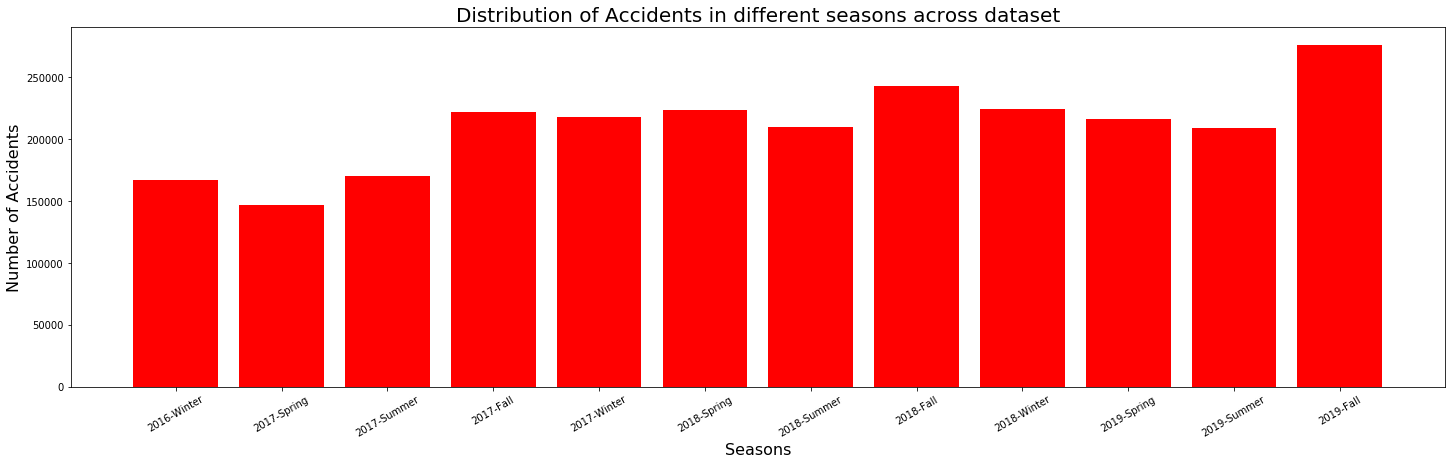

In [61]:
plt.figure(figsize=(20,6))
plt.bar(accident_season_year_us["Season_Year"],accident_season_year_us["Accident Count"],alpha=1.0,color="red",align="center")
_=plt.xticks(rotation=30)
plt.tight_layout()

plt.xlabel("Seasons",fontsize=16)
plt.ylabel("Number of Accidents",fontsize=16)

_=plt.title("Distribution of Accidents in different seasons across dataset",fontsize=20)

plt.savefig("Images\Fig8. Accidents_vs_Seasons")

###### Fall and Winters are the seasons in which most accidents happend compared to other seasons with most accidents happening in Fall in 2017-2019.

### Analysis by Month

In [62]:
#Calling the initial data and creating a new dataFrame
accident_target["Start_Year"]=accident_target["Start_Time"].dt.year
accident_target["Start_Month"]=accident_target["Start_Time"].dt.month
accident_target["Start_Date_Only"]=accident_target["Start_Time"].dt.date

In [63]:
#Calling the initial data and creating a new column for hour
accident_target["Hour"]=accident_target["Start_Time"].dt.hour


In [64]:
accident_target.head()

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,City,County,State,Zipcode,Temperature(F),...,Precipitation(in),Weather_Condition,Sunrise_Sunset,Start_Year,Season,month_year,Season_Year,Start_Month,Start_Date_Only,Hour
0,2,2016-12-01 00:19:29,2016-12-01 01:04:07,38.481644,-121.334816,Sacramento,Sacramento,CA,95829-9422,37.4,...,NaN,NaN,Night,2016,Winter,2016-12,2016-Winter,12,2016-12-01,0
1,2,2016-12-01 01:11:30,2016-12-01 01:41:13,37.421124,-122.092476,Mountain View,Santa Clara,CA,94043,46.9,...,NaN,Clear,Night,2016,Winter,2016-12,2016-Winter,12,2016-12-01,1
2,3,2016-12-01 01:36:51,2016-12-01 02:21:42,37.789349,-122.254303,Oakland,Alameda,CA,94606,46.9,...,NaN,Mostly Cloudy,Night,2016,Winter,2016-12,2016-Winter,12,2016-12-01,1
3,2,2016-12-01 01:34:28,2016-12-01 02:21:01,37.257954,-122.093964,Saratoga,Santa Clara,CA,95070-9704,48.0,...,NaN,Clear,Night,2016,Winter,2016-12,2016-Winter,12,2016-12-01,1
4,2,2016-12-01 01:45:02,2016-12-01 02:14:14,38.004459,-122.038872,Concord,Contra Costa,CA,94520,44.1,...,NaN,Clear,Night,2016,Winter,2016-12,2016-Winter,12,2016-12-01,1


In [65]:
#Creating df for each year to evaluate the number of accidents for each month in each year
accidents_2016_df = accident_target.loc[accident_target['Start_Year']==2016].sort_values(by='Start_Month', ascending=True)
accidents_2017_df = accident_target.loc[accident_target['Start_Year']==2017].sort_values(by='Start_Month', ascending=True)
accidents_2018_df = accident_target.loc[accident_target['Start_Year']==2018].sort_values(by='Start_Month', ascending=True)
accidents_2019_df = accident_target.loc[accident_target['Start_Year']==2019].sort_values(by='Start_Month', ascending=True)
accidents_2016_df.head()

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,City,County,State,Zipcode,Temperature(F),...,Precipitation(in),Weather_Condition,Sunrise_Sunset,Start_Year,Season,month_year,Season_Year,Start_Month,Start_Date_Only,Hour
0,2,2016-12-01 00:19:29,2016-12-01 01:04:07,38.481644,-121.334816,Sacramento,Sacramento,CA,95829-9422,37.4,...,NaN,NaN,Night,2016,Winter,2016-12,2016-Winter,12,2016-12-01,0
71865,2,2016-12-02 17:14:20,2016-12-02 17:59:06,47.684433,-117.414986,Spokane,Spokane,WA,99205-3177,37.0,...,0.00,Light Rain,Night,2016,Winter,2016-12,2016-Winter,12,2016-12-02,17
71866,2,2016-12-02 17:23:59,2016-12-02 18:08:33,47.369980,-122.286919,Kent,King,WA,98032-5654,46.0,...,0.02,Light Rain,Night,2016,Winter,2016-12,2016-Winter,12,2016-12-02,17
71867,3,2016-12-02 17:37:07,2016-12-02 18:21:41,47.821156,-122.279182,Lynnwood,Snohomish,WA,98036,45.0,...,0.01,Light Rain,Night,2016,Winter,2016-12,2016-Winter,12,2016-12-02,17
71868,3,2016-12-02 17:36:19,2016-12-02 18:20:53,47.580242,-122.174667,Bellevue,King,WA,98006,46.9,...,0.00,Light Rain,Night,2016,Winter,2016-12,2016-Winter,12,2016-12-02,17


In [66]:
#Creating new df for accidents per month of each year
accidents_per_month_2016 = accidents_2016_df.groupby(accidents_2016_df['Start_Month']).count()
accidents_per_month_2017 = accidents_2017_df.groupby(accidents_2017_df['Start_Month']).count()
accidents_per_month_2018 = accidents_2018_df.groupby(accidents_2018_df['Start_Month']).count()
accidents_per_month_2019 = accidents_2019_df.groupby(accidents_2019_df['Start_Month']).count()
accidents_per_month_2019.head()

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,City,County,State,Zipcode,Temperature(F),...,Wind_Speed(mph),Precipitation(in),Weather_Condition,Sunrise_Sunset,Start_Year,Season,month_year,Season_Year,Start_Date_Only,Hour
Start_Month,,,,,,,,,,,,,,,,,,,,,
1,79275,79275,79275,79275,79275,79274,79275,79275,79259,77890,...,63039,13653,77572,79274,79275,79275,79275,79275,79275,79275
2,74556,74556,74556,74556,74556,74554,74556,74556,74530,73458,...,60960,18946,73105,74553,74556,74556,74556,74556,74556,74556
3,69396,69396,69396,69396,69396,69395,69396,69396,69370,68382,...,56909,8933,68068,69395,69396,69396,69396,69396,69396,69396
4,73000,73000,73000,73000,73000,72998,73000,73000,72967,72266,...,71837,70258,72216,72998,73000,73000,73000,73000,73000,73000
5,73868,73868,73868,73868,73868,73867,73868,73868,73840,72980,...,72466,70837,72879,73867,73868,73868,73868,73868,73868,73868


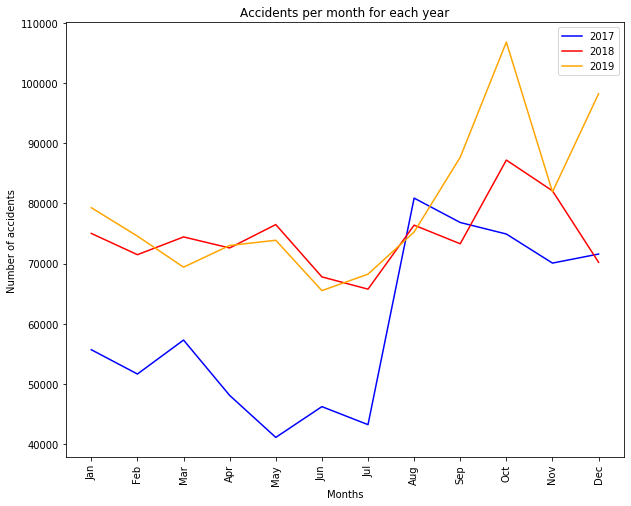

In [67]:
#Plot will show distribution of accidents for each year
#List of months
months = [1,2,3,4,5,6,7,8,9,10,11,12]
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
#Plotting the number of accidents per month for each year

plt.figure(figsize=(10, 8))
plt.plot(months, accidents_per_month_2017['Start_Date_Only'], color="blue", label="2017")
plt.plot(months, accidents_per_month_2018['Start_Date_Only'], color="red", label="2018")
plt.plot(months, accidents_per_month_2019['Start_Date_Only'], color="orange", label="2019")

# Place a legend on the chart in what matplotlib believes to be the "best" location
plt.legend(loc="best")

plt.title("Accidents per month for each year")
plt.xlabel("Months")
plt.ylabel("Number of accidents")
plt.xticks(months, month_names,rotation=90)
plt.savefig("Images/Fig9. AccidentsPerMonthLine.png")

# Print our chart to the screen
plt.show();

##### Accidents per month for the years 2017, 2018 and 2019 show a slight increase in number of accidents in the later part of the year, starting August, with 2018 showing a decrease in December. 

In [68]:
#Creating df for California and NY to evaluate the number of accidents for each month in each year
#California
accidents_CA_2016_df = accident_target.loc[(accident_target['State']=='CA') & (accident_target['Start_Year']==2016)].sort_values(by='Start_Month', ascending=True)
accidents_CA_2017_df = accident_target.loc[(accident_target['State']=='CA') & (accident_target['Start_Year']==2017)].sort_values(by='Start_Month', ascending=True)
accidents_CA_2018_df = accident_target.loc[(accident_target['State']=='CA') & (accident_target['Start_Year']==2018)].sort_values(by='Start_Month', ascending=True)
accidents_CA_2019_df = accident_target.loc[(accident_target['State']=='CA') & (accident_target['Start_Year']==2019)].sort_values(by='Start_Month', ascending=True)

accidents_CA_2019_df.head()

#New York
accidents_NY_2016_df = accident_target.loc[(accident_target['State']=='NY') & (accident_target['Start_Year']==2016)].sort_values(by='Start_Month', ascending=True)
accidents_NY_2017_df = accident_target.loc[(accident_target['State']=='NY') & (accident_target['Start_Year']==2017)].sort_values(by='Start_Month', ascending=True)
accidents_NY_2018_df = accident_target.loc[(accident_target['State']=='NY') & (accident_target['Start_Year']==2018)].sort_values(by='Start_Month', ascending=True)
accidents_NY_2019_df = accident_target.loc[(accident_target['State']=='NY') & (accident_target['Start_Year']==2019)].sort_values(by='Start_Month', ascending=True)

accidents_NY_2019_df.head()

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,City,County,State,Zipcode,Temperature(F),...,Precipitation(in),Weather_Condition,Sunrise_Sunset,Start_Year,Season,month_year,Season_Year,Start_Month,Start_Date_Only,Hour
958857,2,2019-01-29 11:37:18,2019-01-29 12:06:57,41.297817,-73.935936,Cortlandt Manor,Westchester,NY,10567-7300,33.1,...,0.0,Overcast,Day,2019,Winter,2019-1,2018-Winter,1,2019-01-29,11
952177,2,2019-01-25 04:56:00,2019-01-25 05:25:20,40.752480,-73.852135,Corona,Queens,NY,11368,35.1,...,NaN,Mostly Cloudy,Night,2019,Winter,2019-1,2018-Winter,1,2019-01-25,4
952180,2,2019-01-25 05:52:23,2019-01-25 06:22:15,40.692070,-73.765289,Saint Albans,Queens,NY,11412-4025,34.0,...,NaN,Mostly Cloudy,Night,2019,Winter,2019-1,2018-Winter,1,2019-01-25,5
952181,2,2019-01-25 05:52:47,2019-01-25 06:22:30,41.054260,-73.809792,Elmsford,Westchester,NY,10523,32.0,...,NaN,Mostly Cloudy,Night,2019,Winter,2019-1,2018-Winter,1,2019-01-25,5
952182,2,2019-01-25 05:58:20,2019-01-25 06:28:05,40.750229,-73.855141,Corona,Queens,NY,11368-2634,35.1,...,NaN,Overcast,Night,2019,Winter,2019-1,2018-Winter,1,2019-01-25,5


In [69]:
#Grouping by month for California and counting accidents
accidents_per_month_2016_CA = accidents_CA_2016_df.groupby(accidents_CA_2016_df['Start_Month']).count()
accidents_per_month_2017_CA = accidents_CA_2017_df.groupby(accidents_CA_2017_df['Start_Month']).count()
accidents_per_month_2018_CA = accidents_CA_2018_df.groupby(accidents_CA_2018_df['Start_Month']).count()
accidents_per_month_2019_CA = accidents_CA_2019_df.groupby(accidents_CA_2019_df['Start_Month']).count()
accidents_per_month_2019_CA

#Grouping by month for NY and counting accidents
accidents_per_month_2016_NY = accidents_NY_2016_df.groupby(accidents_NY_2016_df['Start_Month']).count()
accidents_per_month_2017_NY = accidents_NY_2017_df.groupby(accidents_NY_2017_df['Start_Month']).count()
accidents_per_month_2018_NY = accidents_NY_2018_df.groupby(accidents_NY_2018_df['Start_Month']).count()
accidents_per_month_2019_NY = accidents_NY_2019_df.groupby(accidents_NY_2019_df['Start_Month']).count()
accidents_per_month_2019_NY.head()

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,City,County,State,Zipcode,Temperature(F),...,Wind_Speed(mph),Precipitation(in),Weather_Condition,Sunrise_Sunset,Start_Year,Season,month_year,Season_Year,Start_Date_Only,Hour
Start_Month,,,,,,,,,,,,,,,,,,,,,
1,3510,3510,3510,3510,3510,3510,3510,3510,3510,3502,...,3140,944,3507,3510,3510,3510,3510,3510,3510,3510
2,3796,3796,3796,3796,3796,3796,3796,3796,3796,3792,...,3299,1105,3794,3796,3796,3796,3796,3796,3796,3796
3,3354,3354,3354,3354,3354,3354,3354,3354,3354,3349,...,2888,691,3347,3354,3354,3354,3354,3354,3354,3354
4,3776,3776,3776,3776,3776,3776,3776,3776,3776,3757,...,3716,3775,3771,3776,3776,3776,3776,3776,3776,3776
5,4262,4262,4262,4262,4262,4262,4262,4262,4262,4256,...,4204,4259,4253,4262,4262,4262,4262,4262,4262,4262


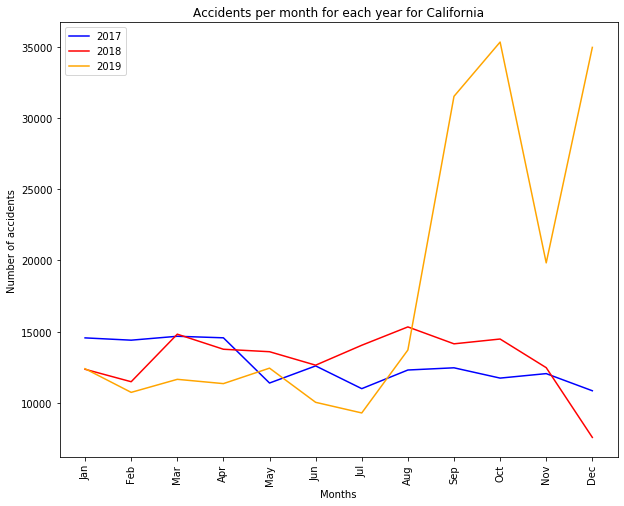

In [70]:
#Plot will show distribution of accidents for each year in California
#List of months
months = [1,2,3,4,5,6,7,8,9,10,11,12]

#Plotting the number of accidents per month for each year

plt.figure(figsize=(10, 8))
plt.plot(months, accidents_per_month_2017_CA['Start_Date_Only'], color="blue", label="2017")
plt.plot(months, accidents_per_month_2018_CA['Start_Date_Only'], color="red", label="2018")
plt.plot(months, accidents_per_month_2019_CA['Start_Date_Only'], color="orange", label="2019")


# Place a legend on the chart in what matplotlib believes to be the "best" location
plt.legend(loc="best")

plt.title("Accidents per month for each year for California")
plt.xlabel("Months")
plt.ylabel("Number of accidents")
plt.xticks(months, month_names,rotation=90)
plt.savefig("Images/Fig10. AccidentsPerMonthLineCAL.png")

# Print our chart to the screen
plt.show();

##### Accidents per month for California in 2017, 2018 and 2019. California does not necesarily show an increase in number of accidents towards the later part of the year for 2017 and 2018, with only an obvious peak in accidents for 2019. 

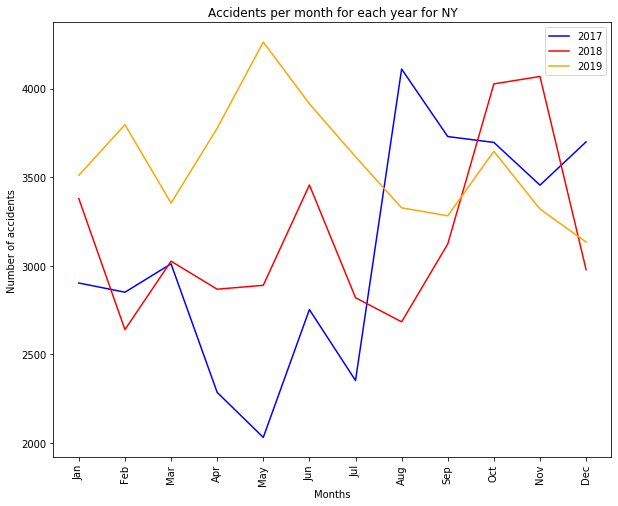

In [71]:
#Plot will show distribution of accidents for each year in New York
#List of months
months = [1,2,3,4,5,6,7,8,9,10,11,12]

#Plotting the number of accidents per month for each year

plt.figure(figsize=(10, 8))
plt.plot(months, accidents_per_month_2017_NY['Start_Date_Only'], color="blue", label="2017")
plt.plot(months, accidents_per_month_2018_NY['Start_Date_Only'], color="red", label="2018")
plt.plot(months, accidents_per_month_2019_NY['Start_Date_Only'], color="orange", label="2019")


# Place a legend on the chart in what matplotlib believes to be the "best" location
plt.legend(loc="best")

plt.title("Accidents per month for each year for NY")
plt.xlabel("Months")
plt.ylabel("Number of accidents")
plt.xticks(months, month_names,rotation=90)
plt.savefig("Images/Fig11. AccidentsPerMonthLineNY.png")

# Print our chart to the screen
plt.show()

##### In New York State there doesn't seem to be any change in number of accidents throughout the year for 2019 with some months dropping and some other months increasing the number randomly. However for 2017 and 2018 there it can be seen that there is an increase in number of accidents after August. 

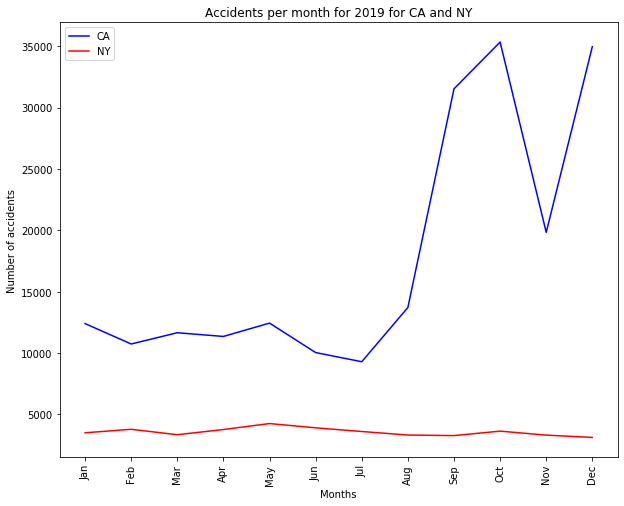

In [72]:
#Plot will show distribution of accidents for California and for New York in the year 2019
#List of months
months = [1,2,3,4,5,6,7,8,9,10,11,12]

#Plotting the number of accidents per month for California in 2019
plt.figure(figsize=(10, 8))
plt.plot(months, accidents_per_month_2019_CA['Start_Date_Only'], color="blue", label="CA")

#Plotting the number of accidents per month for New York in 2019
plt.plot(months, accidents_per_month_2019_NY['Start_Date_Only'], color="red", label="NY")



# Place a legend on the chart in what matplotlib believes to be the "best" location
plt.legend(loc="best")

plt.title("Accidents per month for 2019 for CA and NY")
plt.xlabel("Months")
plt.ylabel("Number of accidents")
plt.xticks(months, month_names,rotation=90)
plt.savefig("Images/Fig12. AccidentsPerMonthLineNYca2019_.png")

# Print our chart to the screen
plt.show()

##### When we compare California and New York the previous observations remain. For 2019 there is an increase in number of accidents towards the end of the year for California but not for New York. 

### Time of Hour Analysis

In [73]:
#Grouping by hour and counting accidents for the whole dataset
accidents_per_hour = accident_target.groupby(accident_target['Hour']).count()
accidents_per_hour.head()

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,City,County,State,Zipcode,Temperature(F),...,Wind_Speed(mph),Precipitation(in),Weather_Condition,Sunrise_Sunset,Start_Year,Season,month_year,Season_Year,Start_Month,Start_Date_Only
Hour,,,,,,,,,,,,,,,,,,,,,
0,19440,19440,19440,19440,19440,19440,19440,19440,19412,18873,...,14764,7860,18876,19434,19440,19440,19440,19440,19440,19440
1,15085,15085,15085,15085,15085,15084,15085,15085,15070,14695,...,11180,5783,14744,15084,15085,15085,15085,15085,15085,15085
2,16171,16171,16171,16171,16171,16171,16171,16171,16159,15743,...,11892,5941,15782,16171,16171,16171,16171,16171,16171,16171
3,15690,15690,15690,15690,15690,15690,15690,15690,15677,15320,...,11623,5761,15347,15690,15690,15690,15690,15690,15690,15690
4,49109,49109,49109,49109,49109,49105,49109,49109,49096,48019,...,37967,19940,47866,49105,49109,49109,49109,49109,49109,49109


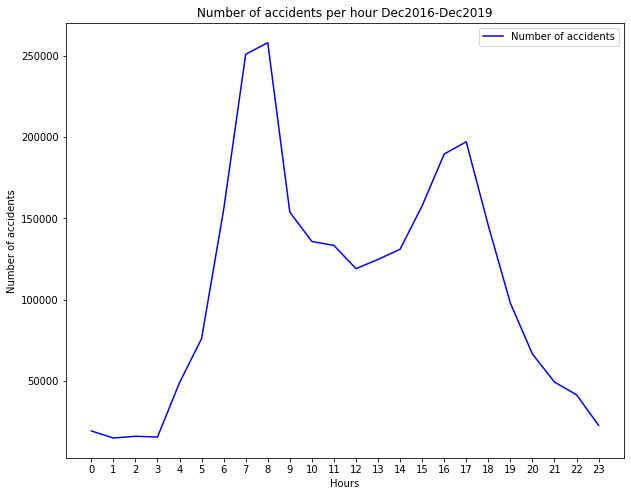

In [74]:
#Plot will show distribution of accidents throughout the hours of the day for the whole dataset
#List of hours
hours = accidents_per_hour.index

#Plotting the number of accidents per hour
plt.figure(figsize=(10, 8))
plt.plot(hours, accidents_per_hour['Start_Date_Only'], color="blue", label="Number of accidents")

# Place a legend on the chart in what matplotlib believes to be the "best" location
plt.legend(loc="best")

plt.title("Number of accidents per hour Dec2016-Dec2019")
plt.xlabel("Hours")
plt.ylabel("Number of accidents")
plt.xticks(hours, hours ,rotation=0)
plt.savefig("Images/Fig13. AccidentsPerHour.png")

# Print our chart to the screen
plt.show()

##### This graph shows the hourly distribution of accidents. It is very obvious that there is a larger number of accidents occuring during rush hours in the morning between 7am and 9am and in the afternoon between 4pm and 6pm. 

In [75]:
#Cresting the Dataframe with the whole data for CA, NY
accidents_CA = accident_target.loc[accident_target['State']=='CA']
accidents_NY = accident_target.loc[accident_target['State']=='NY']

In [76]:
#Grouping by month for California and counting accidents
accidents_per_hour_CA = accidents_CA.groupby(accidents_CA['Hour']).count()

#Grouping by month for NY and counting accidents
accidents_per_hour_NY = accidents_NY.groupby(accidents_NY['Hour']).count()

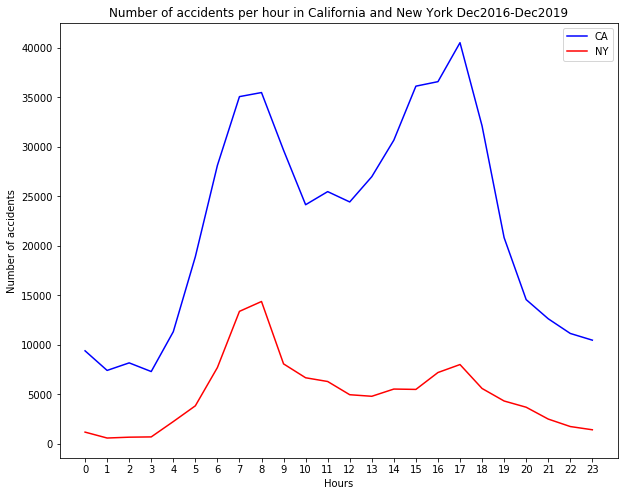

In [77]:
#Plot will show distribution of accidents throughout the hours of the day for California and New York
#List of hours
hours = accidents_per_hour.index

#Plotting the number of accidents per hour in California
plt.figure(figsize=(10, 8))
plt.plot(hours, accidents_per_hour_CA['Start_Date_Only'], color="blue", label="CA")

#Plotting the number of accidents per hour in New York
plt.plot(hours, accidents_per_hour_NY['Start_Date_Only'], color="red", label="NY")

# Place a legend on the chart in what matplotlib believes to be the "best" location
plt.legend(loc="best")

plt.title("Number of accidents per hour in California and New York Dec2016-Dec2019")
plt.xlabel("Hours")
plt.ylabel("Number of accidents")
plt.xticks(hours, hours ,rotation=0)
plt.savefig("Images/Fig14. AccidentsPerHourCALny.png")

# Print our chart to the screen
plt.show()

##### The relation of number of accidents to rush hour is present here for New York and California with a most obvious peak in California in both morning and afternoon rush hour but only for morning rush hour in New York. 

In [78]:
#Grouping by month for California and counting accidents
accidents_per_hour_2016_CA = accidents_CA_2016_df.groupby(accidents_CA_2016_df['Hour']).count()
accidents_per_hour_2017_CA = accidents_CA_2017_df.groupby(accidents_CA_2017_df['Hour']).count()
accidents_per_hour_2018_CA = accidents_CA_2018_df.groupby(accidents_CA_2018_df['Hour']).count()
accidents_per_hour_2019_CA = accidents_CA_2019_df.groupby(accidents_CA_2019_df['Hour']).count()
accidents_per_hour_2019_CA

#Grouping by month for NY and counting accidents
accidents_per_hour_2016_NY = accidents_NY_2016_df.groupby(accidents_NY_2016_df['Hour']).count()
accidents_per_hour_2017_NY = accidents_NY_2017_df.groupby(accidents_NY_2017_df['Hour']).count()
accidents_per_hour_2018_NY = accidents_NY_2018_df.groupby(accidents_NY_2018_df['Hour']).count()
accidents_per_hour_2019_NY = accidents_NY_2019_df.groupby(accidents_NY_2019_df['Hour']).count()
accidents_per_hour_2019_NY.head()

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,City,County,State,Zipcode,Temperature(F),...,Wind_Speed(mph),Precipitation(in),Weather_Condition,Sunrise_Sunset,Start_Year,Season,month_year,Season_Year,Start_Month,Start_Date_Only
Hour,,,,,,,,,,,,,,,,,,,,,
0,481,481,481,481,481,481,481,481,481,478,...,461,432,478,481,481,481,481,481,481,481
1,170,170,170,170,170,170,170,170,170,170,...,160,145,169,170,170,170,170,170,170,170
2,214,214,214,214,214,214,214,214,214,214,...,199,166,214,214,214,214,214,214,214,214
3,191,191,191,191,191,191,191,191,191,190,...,185,164,191,191,191,191,191,191,191,191
4,877,877,877,877,877,877,877,877,877,875,...,834,712,874,877,877,877,877,877,877,877


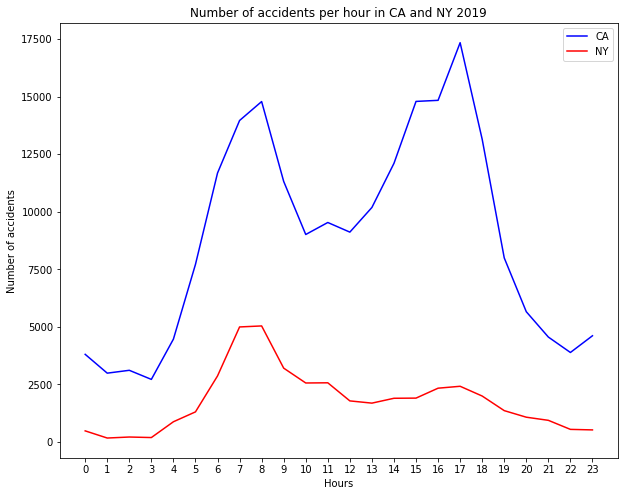

In [79]:
#Plot will show distribution of accidents throughout the hours of the day for California and New York in 2019
#List of hours
hours = accidents_per_hour.index

#Plotting the number of accidents per hour in California
plt.figure(figsize=(10, 8))
plt.plot(hours, accidents_per_hour_2019_CA['Start_Date_Only'], color="blue", label="CA")

#Plotting the number of accidents per hour in New York
plt.plot(hours, accidents_per_hour_2019_NY['Start_Date_Only'], color="red", label="NY")

# Place a legend on the chart in what matplotlib believes to be the "best" location
plt.legend(loc="best")

plt.title("Number of accidents per hour in CA and NY 2019")
plt.xlabel("Hours")
plt.ylabel("Number of accidents")
plt.xticks(hours, hours ,rotation=0)
plt.savefig("Images/Fig15. AccidentsPerHourCALny2019.png")

# Print our chart to the screen
plt.show()

###### In 2019 the relation to rush hour remains for both California and New York.

# Weather Conditions

In [80]:
accident_target['Weather_Condition'].isna().sum()

58642

In [81]:
##RUN this code only if we want to replace NaN values for weather conditions with 'Clear'
#accident_target['Weather_Condition'].replace(np.nan, 'Clear')

In [82]:
#Grouping by weather condition and counting each condition
accidents_per_weather_condition = accident_target.groupby(accident_target['Weather_Condition']).count()
accidents_per_weather_condition_df = accidents_per_weather_condition.reset_index()
accidents_per_weather_condition_df.sort_values(by= 'Severity', ascending=False)

,Weather_Condition,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,City,County,State,Zipcode,...,Wind_Speed(mph),Precipitation(in),Sunrise_Sunset,Start_Year,Season,month_year,Season_Year,Start_Month,Start_Date_Only,Hour
4,Clear,652972,652972,652972,652972,652972,652956,652972,652972,652972,...,499200,4053,652956,652972,652972,652972,652972,652972,652972,652972
71,Mostly Cloudy,366359,366359,366359,366359,366359,366354,366359,366359,366359,...,333013,114546,366353,366359,366359,366359,366359,366359,366359,366359
74,Overcast,340627,340627,340627,340627,340627,340624,340627,340627,340627,...,289642,49026,340624,340627,340627,340627,340627,340627,340627,340627
11,Fair,333090,333090,333090,333090,333090,333084,333090,333090,333090,...,330187,317163,333082,333090,333090,333090,333090,333090,333090,333090
77,Partly Cloudy,257764,257764,257764,257764,257764,257762,257764,257764,257764,...,234058,85317,257762,257764,257764,257764,257764,257764,257764,257764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,Dust Whirls,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,1,1,1,1
108,Thunder and Hail / Windy,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
107,Thunder / Wintry Mix / Windy,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
30,Heavy Smoke,1,1,1,1,1,1,1,1,1,...,0,0,1,1,1,1,1,1,1,1


In [83]:
#Removing Values with little occurance
accidents_per_weather_condition_clean = accidents_per_weather_condition_df.loc[accidents_per_weather_condition_df["Severity"]>=1000]
accidents_per_weather_condition_clean.sort_values(by="Severity", ascending=False).head()

,Weather_Condition,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,City,County,State,Zipcode,...,Wind_Speed(mph),Precipitation(in),Sunrise_Sunset,Start_Year,Season,month_year,Season_Year,Start_Month,Start_Date_Only,Hour
4,Clear,652972,652972,652972,652972,652972,652956,652972,652972,652972,...,499200,4053,652956,652972,652972,652972,652972,652972,652972,652972
71,Mostly Cloudy,366359,366359,366359,366359,366359,366354,366359,366359,366359,...,333013,114546,366353,366359,366359,366359,366359,366359,366359,366359
74,Overcast,340627,340627,340627,340627,340627,340624,340627,340627,340627,...,289642,49026,340624,340627,340627,340627,340627,340627,340627,340627
11,Fair,333090,333090,333090,333090,333090,333084,333090,333090,333090,...,330187,317163,333082,333090,333090,333090,333090,333090,333090,333090
77,Partly Cloudy,257764,257764,257764,257764,257764,257762,257764,257764,257764,...,234058,85317,257762,257764,257764,257764,257764,257764,257764,257764


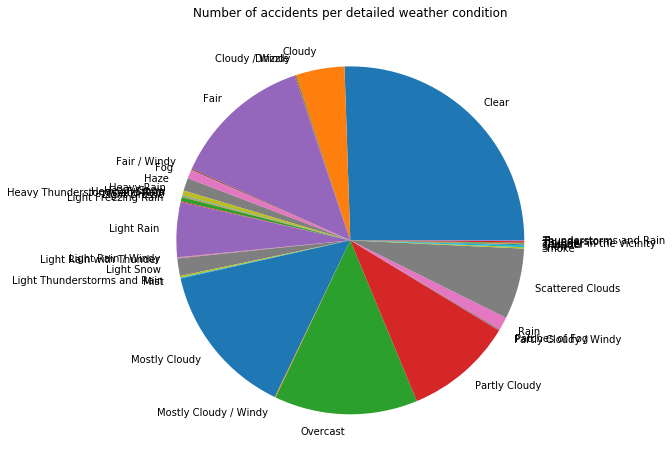

In [84]:
#Number of accidents per detailed weather condition.
plt.figure(figsize=(10, 8))
plt.title("Number of accidents per detailed weather condition")

#explode = (0.1)
plt.pie(accidents_per_weather_condition_clean["Severity"],labels= accidents_per_weather_condition_clean['Weather_Condition'])

plt.savefig("Images/Fig16. Number of accidents per detailed weather condition.png")
plt.show()

In [85]:
accidents_per_weather_condition_df['Weather_Condition'].value_counts()

Light Rain                      1
Thunderstorms and Snow          1
Light Snow with Thunder         1
Light Freezing Rain / Windy     1
Thunder / Wintry Mix / Windy    1
                               ..
Widespread Dust / Windy         1
Light Rain Shower / Windy       1
Heavy Snow                      1
Heavy Freezing Drizzle          1
Scattered Clouds                1
Name: Weather_Condition, Length: 119, dtype: int64

In [86]:
#Regrouping detail of weather conditions into 5 most relevant categories. 
#List of categories for weather conditions
sleet = ['Freezing Rain', 'Freezing Rain / Windy', 'Heavy Ice Pellets', 'Heavy Sleet', 'Ice Pellets', 'Light Freezing Rain', 'Light Freezing Rain / Windy', 'Light Ice Pellets', 'Light Sleet', 'Light Snow and Sleet / Windy', 'Sleet', 'Small Hail',  'Thunder and Hail / Windy', 'Hail', 'Light Hail' ]

snow = ['Blowing Snow', 'Blowing Snow / Windy', 'Heavy Blowing Snow', 'Heavy Snow', 'Heavy Snow / Windy', 'Heavy Snow with Thunder', 'Heavy Thunderstorms and Snow','Light Blowing Snow', 'Light Snow', 'Light Snow / Windy', 'Light Snow Grains','Light Snow Shower', 'Light Snow Showers', 'Light Snow and Sleet','Snow Showers', 'Light Snow with Thunder', 'Light Thunderstorms and Snow', 'Low Drifting Snow', 'Snow', 'Snow / Windy','Snow Grains','Snow and Sleet','Snow and Sleet / Windy', 'Snow and Thunder', 'Thunderstorms and Snow']

rain = ['Heavy Drizzle','Drizzle', 'Light Rain / Windy','Drizzle / Windy', 'Heavy Freezing Rain', 'Heavy Freezing Drizzle', 'Heavy Rain', 'Heavy Rain / Windy', 'Heavy Rain Showers', 'Heavy T-Storm', 'Heavy T-Storm / Windy', 'Heavy Thunderstorms and Rain', 'Heavy Thunderstorms with Small Hail', 'Light Rain Shower', 'Light Rain Shower / Windy', 'Light Rain Showers', 'Light Rain with Thunder', 'Light Thunderstorm', 'Light Thunderstorms and Rain', 'Rain', 'Rain / Windy', 'Rain Shower', 'Rain Showers', 'Squalls', 'Squalls / Windy', 'T-Storm', 'T-Storm / Windy', 'Thunderstorm', 'Thunderstorms and Rain', 'Wintry Mix', 'Wintry Mix / Windy', 'N/A Precipitation', 'Light Drizzle', 'Light Drizzle / Windy', 'Light Freezing Drizzle', 'Light Rain']

fog = ['Drizzle and Fog', 'Dust Whirls', 'Fog', 'Fog / Windy', 'Haze', 'Haze / Windy', 'Light Fog', 'Heavy Smoke', 'Light Freezing Fog', 'Light Haze', 'Mist', 'Partial Fog', 'Patches of Fog', 'Shallow Fog', 'Smoke', 'Smoke / Windy', 'Volcanic Ash', 'Widespread Dust']

wind = ['Blowing Dust','Partial Fog / Windy', 'Blowing Dust / Windy', 'Cloudy / Windy', 'Sand / Dust Whirlwinds','Sand / Dust Whirlwinds / Windy', 'Funnel Cloud', 'Thunder / Windy', 'Thunder / Wintry Mix / Windy','Tornado', 'Widespread Dust / Windy', 'Dust Whirls', 'Sand']

clear= ['Clear', 'Cloudy', 'Fair', 'Fair / Windy', 'Mostly Cloudy', 'Mostly Cloudy / Windy', 'Overcast', 'Partly Cloudy', 'Partly Cloudy / Windy', 'Scattered Clouds', 'Showers in the Vicinity', 'Thunder', 'Thunder in the Vicinity']


In [87]:
# Replacing the weather conditions to group them into 6 cagetories. 
accident_target_new = accident_target.replace(sleet, 'sleet')
accident_target_new = accident_target_new.replace(snow, 'snow')
accident_target_new = accident_target_new.replace(rain, 'rain')
accident_target_new = accident_target_new.replace(fog, 'fog')
accident_target_new = accident_target_new.replace(wind, 'wind')
accident_target_new = accident_target_new.replace(clear, 'clear')

In [88]:
#Checking the new categories
accident_target_new['Weather_Condition'].value_counts()

clear    2245394
rain      204491
fog        61378
snow       48493
sleet       2553
wind        2351
Name: Weather_Condition, dtype: int64

In [89]:
#Confirming that all the categories have been replaced effectively. 
accident_per_weather_category = accident_target_new.groupby(accident_target_new['Weather_Condition']).count()
accident_per_weather_category.sort_values( by = "Severity", ascending = False)

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,City,County,State,Zipcode,Temperature(F),...,Precipitation(in),Weather_Condition,Sunrise_Sunset,Start_Year,Season,month_year,Season_Year,Start_Month,Start_Date_Only,Hour
Weather_Condition,,,,,,,,,,,,,,,,,,,,,
clear,2245394,2245394,2245394,2245394,2245394,2245353,2245394,2245394,2245394,2238221,...,695838,2245394,2245350,2245394,2245394,2245394,2245394,2245394,2245394,2245394
rain,204491,204491,204491,204491,204491,204481,204491,204491,204491,203737,...,180332,204491,204481,204491,204491,204491,204491,204491,204491,204491
fog,61378,61378,61378,61378,61378,61377,61378,61378,61378,60892,...,20070,61378,61377,61378,61378,61378,61378,61378,61378,61378
snow,48493,48493,48493,48493,48493,48491,48493,48493,48493,48446,...,40974,48493,48491,48493,48493,48493,48493,48493,48493,48493
sleet,2553,2553,2553,2553,2553,2553,2553,2553,2553,2547,...,2264,2553,2553,2553,2553,2553,2553,2553,2553,2553
wind,2351,2351,2351,2351,2351,2351,2351,2351,2351,2327,...,2210,2351,2351,2351,2351,2351,2351,2351,2351,2351


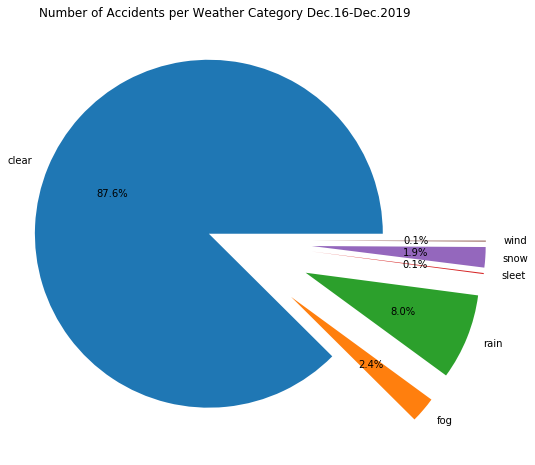

In [90]:
#Presenting the number of accidents per Weather Category.
plt.figure(figsize=(10, 8))
plt.title("Number of Accidents per Weather Category Dec.16-Dec.2019")
explode = (0.1, 0.5,0.5,0.5,0.5,0.5)
labels = accident_per_weather_category.index
#['clear','fog','rain', 'sleet','snow', 'wind']
plt.pie(accident_per_weather_category["Severity"], explode=explode, labels=labels, autopct="%1.1f%%")

# Save and display the chart

plt.savefig("Images/Fig17. Number of accidents per detailed weather condition.png")
plt.show()

##### Approximately 13.4% of the accidents between december 2016 and december 2019 ocurred during inclement weather conditions. Of those rain fog and snow seem to have the most number of accidents.

In [91]:
accident_per_weather_category_df = accident_per_weather_category.rename(columns={"Weather_Condition": "Weather_Count"})

In [92]:
accident_per_weather_category_df.reset_index(inplace=True)

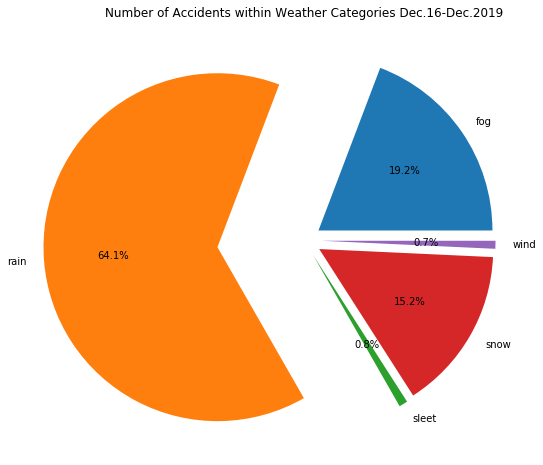

In [93]:
weather_accidents = accident_per_weather_category_df.loc[accident_per_weather_category_df['Weather_Condition'] != 'clear']
weather_accidents#Presenting the number of accidents within the Weather Categories.
plt.figure(figsize=(10, 8))
plt.title("Number of Accidents within Weather Categories Dec.16-Dec.2019")
explode = (0.1,0.5,0.1,0.1,0.1)
labels = weather_accidents['Weather_Condition']
plt.pie(weather_accidents["Severity"], explode=explode, labels=labels, autopct="%1.1f%%")

# Save and display the chart
plt.savefig("Images/Fig18. Number of accidents per weather condition category.png")
plt.show()

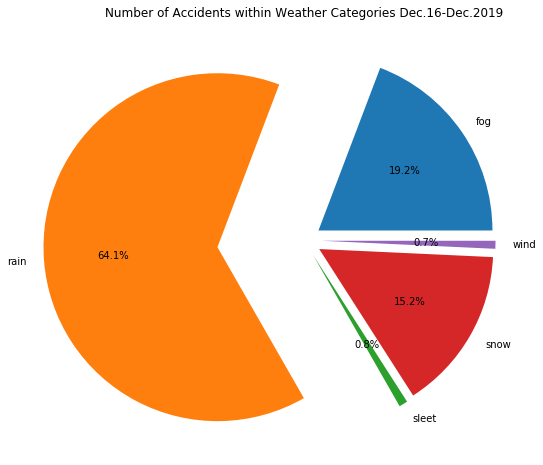

In [94]:
#Presenting the number of accidents within the Weather Categories.
plt.figure(figsize=(10, 8))
plt.title("Number of Accidents within Weather Categories Dec.16-Dec.2019")
explode = (0.1,0.5,0.1,0.1,0.1)
labels = weather_accidents['Weather_Condition']
plt.pie(weather_accidents["Severity"], explode=explode, labels=labels, autopct="%1.1f%%")

# Save and display the chart
plt.savefig("Images/Fig19. Number of accidents per weather condition category.png")
plt.show()

##### Most weather related accidents are caused by wet roads accounting to 64.1% of all weather related accidents.

In [104]:
accident_target_weather_related = accident_target_new.loc[accident_target_new['Weather_Condition'] != 'clear'] 
accident_target_weather_related

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,City,County,State,Zipcode,Temperature(F),...,Precipitation(in),Weather_Condition,Sunrise_Sunset,Start_Year,Season,month_year,Season_Year,Start_Month,Start_Date_Only,Hour
0,2,2016-12-01 00:19:29,2016-12-01 01:04:07,38.481644,-121.334816,Sacramento,Sacramento,CA,95829-9422,37.4,...,NaN,NaN,Night,2016,Winter,2016-12,2016-Winter,12,2016-12-01,0
346,2,2016-12-03 12:54:41,2016-12-03 13:24:29,38.678440,-121.225563,Orangevale,Sacramento,CA,95662-4023,53.6,...,NaN,fog,Day,2016,Winter,2016-12,2016-Winter,12,2016-12-03,12
415,2,2016-12-04 10:10:05,2016-12-04 11:09:50,38.059361,-121.460106,Stockton,San Joaquin,CA,95219,48.9,...,NaN,fog,Day,2016,Winter,2016-12,2016-Winter,12,2016-12-04,10
419,3,2016-12-04 11:13:04,2016-12-04 12:12:43,38.631790,-121.398041,Sacramento,Sacramento,CA,95821,53.6,...,NaN,fog,Day,2016,Winter,2016-12,2016-Winter,12,2016-12-04,11
424,2,2016-12-04 11:43:12,2016-12-04 12:42:53,37.700020,-121.071472,Salida,Stanislaus,CA,95368,57.0,...,NaN,fog,Day,2016,Winter,2016-12,2016-Winter,12,2016-12-04,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2623064,2,2019-08-23 12:23:00,2019-08-23 13:45:00,40.705620,-111.546730,Park City,Summit,UT,84098-5954,NaN,...,NaN,NaN,Day,2019,Summer,2019-8,2019-Summer,8,2019-08-23,12
2623070,2,2019-08-23 13:23:00,2019-08-23 14:30:00,40.792697,-111.450383,Coalville,Summit,UT,84017,NaN,...,NaN,NaN,Day,2019,Summer,2019-8,2019-Summer,8,2019-08-23,13
2623158,2,2019-08-23 17:19:55,2019-08-24 03:11:30,44.119763,-121.317222,Bend,Deschutes,OR,97703-8588,NaN,...,NaN,NaN,Day,2019,Summer,2019-8,2019-Summer,8,2019-08-23,17
2623213,2,2019-08-23 23:48:20,2019-08-24 03:48:20,44.157060,-121.261170,Bend,Deschutes,OR,97703,NaN,...,NaN,NaN,Night,2019,Summer,2019-8,2019-Summer,8,2019-08-23,23


# Analyze impact of Weather Factors on Number of Accident across data

In [105]:
#Create function to calculate linear regression and correlation co-efficient for factors against accident

def factor_accident_correlation(factor,line_x,line_y):
    accident_count_factor=accident_target_weather_related.groupby(factor).count().reset_index()
    #accident_count_humidity.head()
    x_axis=accident_count_factor[factor]
    y_axis=accident_count_factor["Start_Time"]
    
    #fig=plt.figure(figsize=(12,8))
    
    _=plt.scatter(x_axis,y_axis)
    
    plt.title(f"Number of Accidents vs {factor}")
    plt.xlabel(f"{factor}")
    plt.ylabel("Number of Accidents")
    
    #plt.yticks(np.arange(min(accident_count_factor["Start_Time"]),max(accident_count_factor["Start_Time"])+10000,10000))
    
    #plt.xticks(np.arange(min(accident_count_factor[factor]),max(accident_count_factor[factor])+5,10))
    
    slope,intercept,p,r,stderr=linregress(x_axis,y_axis)
    
    line_eq=f"y= {round(slope,2)}*x + {round(intercept,2)}"
    
    plt.plot(x_axis,((slope*x_axis)+intercept),"r--")
    
    _=plt.annotate(line_eq,(line_x,line_y),color="red",fontsize=15)
    
    corr,pvalue=pearsonr(accident_count_factor[factor],accident_count_factor["Start_Time"])
    
    plt.tight_layout()
    
    print(f"The correlation-co-efficient is: {round(corr,4)}")
    

## Analyze impact of Humidity on Number of Accident across data

The correlation-co-efficient is: 0.5738


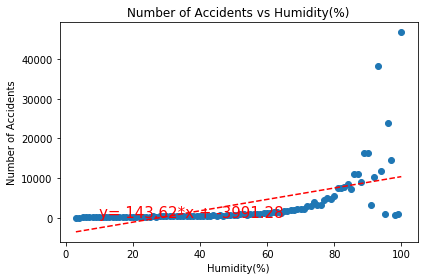

In [106]:
factor_accident_correlation('Humidity(%)',10,50)

## Analyze impact of Temperature on Number of Accident across data

The correlation-co-efficient is: 0.0989


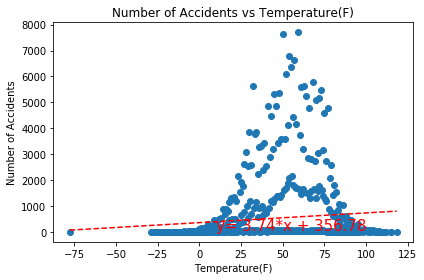

In [107]:
factor_accident_correlation('Temperature(F)',10,50)

## Analyze impact of Visibility on Number of Accident across data

The correlation-co-efficient is: -0.1689


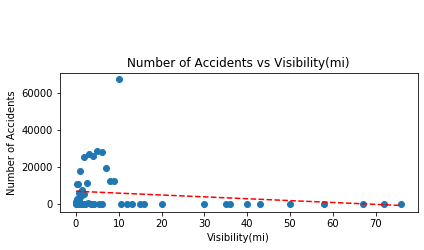

In [108]:
factor_accident_correlation('Visibility(mi)',10,100000)

The correlation-co-efficient is: -0.2259


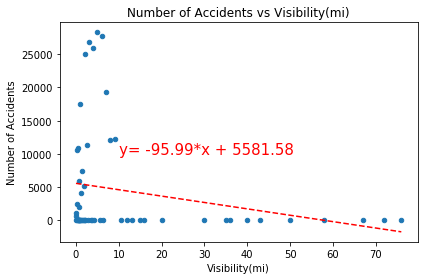

In [109]:
# Since the data is skewed due to a big value of Accidents for Visibility: 10 mi 
#Hence removing the value to see the correlaton of Visibility with Accidents without outlier value of 10 mi

factor="Visibility(mi)"
accident_count_factor=accident_target_weather_related.loc[accident_target_weather_related[factor]!=10.0].groupby(factor).count().reset_index()
x_axis=accident_count_factor[factor]
y_axis=accident_count_factor["Start_Time"]

#fig=plt.figure(figsize=(10,6))

_=plt.scatter(x_axis,y_axis,s=20)

plt.title(f"Number of Accidents vs {factor}")
plt.xlabel(f"{factor}")
plt.ylabel("Number of Accidents")

#plt.yticks(np.arange(min(accident_count_factor["Start_Time"]),max(accident_count_factor["Start_Time"])+10000,10000))

#plt.xticks(np.arange(min(accident_count_factor[factor]),max(accident_count_factor[factor])+5,10))

slope,intercept,p,r,stderr=linregress(x_axis,y_axis)

line_eq=f"y= {round(slope,2)}*x + {round(intercept,2)}"

plt.plot(x_axis,((slope*x_axis)+intercept),"r--")

_=plt.annotate(line_eq,(10,10000),color="red",fontsize=15)

corr,pvalue=pearsonr(accident_count_factor[factor],accident_count_factor["Start_Time"])
    
plt.tight_layout()
    
print(f"The correlation-co-efficient is: {round(corr,4)}")

## Analyze impact of Wind Speed on Number of Accident across data

The correlation-co-efficient is: -0.3738


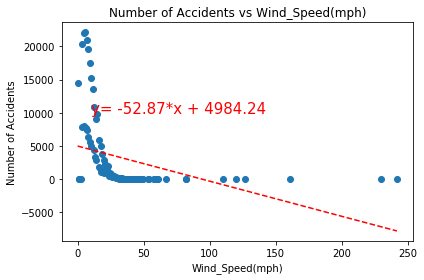

In [111]:
factor_accident_correlation('Wind_Speed(mph)',10,10000)

The correlation-co-efficient is: -0.5816


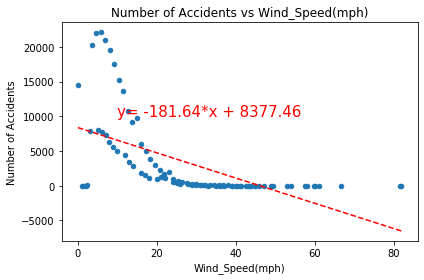

In [112]:
# Since there are very few values with wind speed above 100 mph and is not possible value of wind speed in general 
#Hence removing all the rows with WindSpeed greater than 100 mph to see the correlaton of Wind Speed with Accidents 

factor="Wind_Speed(mph)"
accident_count_factor=accident_target_weather_related.loc[accident_target_weather_related[factor]<=100].groupby(factor).count().reset_index()
x_axis=accident_count_factor[factor]
y_axis=accident_count_factor["Start_Time"]

#fig=plt.figure(figsize=(10,6))

_=plt.scatter(x_axis,y_axis,s=20)

plt.title(f"Number of Accidents vs {factor}")
plt.xlabel(f"{factor}")
plt.ylabel("Number of Accidents")

#plt.yticks(np.arange(min(accident_count_factor["Start_Time"]),max(accident_count_factor["Start_Time"])+10000,10000))

#plt.xticks(np.arange(min(accident_count_factor[factor]),max(accident_count_factor[factor])+5,10))

slope,intercept,p,r,stderr=linregress(x_axis,y_axis)

line_eq=f"y= {round(slope,2)}*x + {round(intercept,2)}"

plt.plot(x_axis,((slope*x_axis)+intercept),"r--")

_=plt.annotate(line_eq,(10,10000),color="red",fontsize=15)

corr,pvalue=pearsonr(accident_count_factor[factor],accident_count_factor["Start_Time"])
    
plt.tight_layout()
    
print(f"The correlation-co-efficient is: {round(corr,4)}")

## Analyze impact of different weather factors on Number of Accident across data

In [113]:
multi_factor=["Temperature(F)","Humidity(%)","Visibility(mi)","Wind_Speed(mph)"]

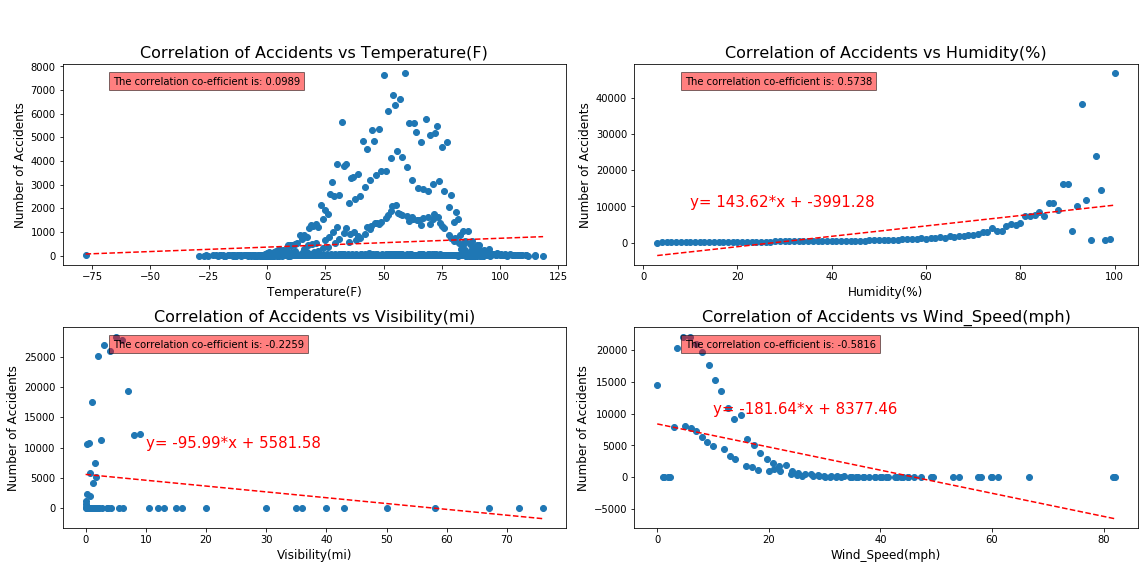

In [114]:
fig,ax =  plt.subplots(2,2,figsize=(16,8))
#fig=plt.figure(figsize=(20,8))

#multi_factor=["Humidity(%)","Visibility(mi)","Temperature(F)","Wind_Speed(mph)"]
#,"Precipitation(in)"
x_cord=0
y_cord=0

for factor in multi_factor:
    
    #.loc[accident_target[factor]!=10.0]
    if factor=="Wind_Speed(mph)":
        accident_count_factor=accident_target_weather_related.loc[accident_target_weather_related[factor]<=100].groupby(factor).count().reset_index()
        x_axis=accident_count_factor[factor]
        y_axis=accident_count_factor["Start_Time"]
    elif factor=="Visibility(mi)":
        accident_count_factor=accident_target_weather_related.loc[accident_target_weather_related[factor]!=10.0].groupby(factor).count().reset_index()
        x_axis=accident_count_factor[factor]
        y_axis=accident_count_factor["Start_Time"]
    else:
        accident_count_factor=accident_target_weather_related.groupby(factor).count().reset_index()
        x_axis=accident_count_factor[factor]
        y_axis=accident_count_factor["Start_Time"]
    
   

    ax[x_cord][y_cord].scatter(x_axis,y_axis)
    
    ax[x_cord][y_cord].set_title(f"Correlation of Accidents vs {factor}",fontsize=16)
    ax[x_cord][y_cord].set_xlabel(f"{factor}",fontsize=12)
    ax[x_cord][y_cord].set_ylabel("Number of Accidents",fontsize=12)

    #plt.yticks(np.arange(min(accident_count_factor["Start_Time"]),max(accident_count_factor["Start_Time"])+10000,10000))

    #plt.xticks(np.arange(min(accident_count_factor[factor]),max(accident_count_factor[factor])+5,10))

    slope,intercept,p,r,stderr=linregress(x_axis,y_axis)

    line_eq=f"y= {round(slope,2)}*x + {round(intercept,2)}"
    
    corr,pvalue=pearsonr(accident_count_factor[factor],accident_count_factor["Start_Time"])

    ax[x_cord][y_cord].plot(x_axis,((slope*x_axis)+intercept),"r--")

    ax[x_cord][y_cord].annotate(line_eq,(10,10000),color="red",fontsize=15)
    
    ax[x_cord][y_cord].text(0.1, 0.9,f"The correlation co-efficient is: {round(corr,4)}", transform=ax[x_cord][y_cord].transAxes,bbox=dict(facecolor='red', alpha=0.5))
    
    #imagepath=f"Images/Accidents_vs_factors"
    
    
    
    if(x_cord==0 and y_cord==0):
        y_cord=1
    elif (x_cord==0 and y_cord==1):
        x_cord=1
        y_cord=0
    elif (x_cord==1 and y_cord==0):
        y_cord=1
       

    plt.tight_layout()
    
    plt.savefig("Images/Fig20. Accidents_vs_factors")

    #print(f"The r-squared value for Number of Accidents vs {factor} is: {r**2}")
    


###### The correlation co-efficient factor between Accidents and Temperature is 0.1402 which shows a weak correlation between temperature and accidents. The distribution of number of accidents in US follows the distribution of temperature across state across year. 

###### The correlation co-efficient factor between Accidents and Humidity is 0.7223 which shows a very high correlation between humidity and accidents.
###### The correlation co-efficient factor between Accidents and Visibility is -0.2266 which shows a negative correlation between Visibility and accidents. As we can see from the graph that more accidents tend to happen when the visibility is lower. 

###### The correlation co-efficient factor between Accidents and Wind Speed is -0.5445 which shows a moderately negative correlation between Wind speed and accidents. More accidents tend to happen when Wind speed is low.

In [ ]:
weather_accidents

## Analyze impact of various weather factors on Number of Accident in Calfornia

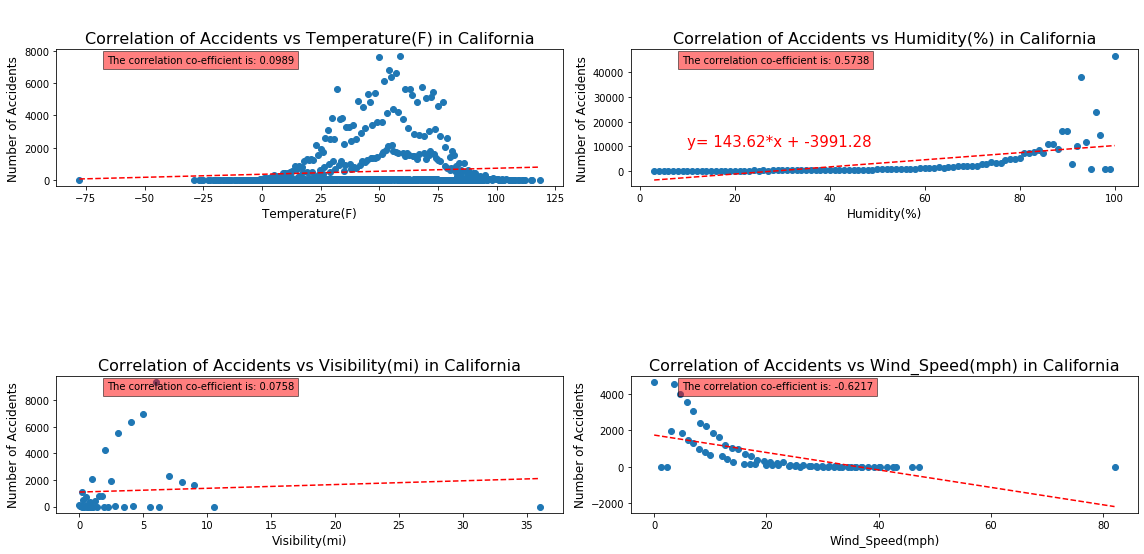

In [115]:
fig,ax =  plt.subplots(2,2,figsize=(16,8))
#fig=plt.figure(figsize=(20,8))

#multi_factor=["Humidity(%)","Visibility(mi)","Temperature(F)","Wind_Speed(mph)"]
#,"Precipitation(in)"
x_cord=0
y_cord=0

for factor in multi_factor:
    
    if factor=="Wind_Speed(mph)":
        accident_count_factor=accident_target_weather_related.loc[(accident_target_weather_related[factor]<=100) & (accident_target_weather_related["State"]=="CA")].groupby(factor).count().reset_index()
        x_axis=accident_count_factor[factor]
        y_axis=accident_count_factor["Start_Time"]
    elif factor=="Visibility(mi)":
        accident_count_factor=accident_target_weather_related.loc[(accident_target_weather_related[factor]!=10.0) & (accident_target_weather_related["State"]=="CA")].groupby(factor).count().reset_index()
        x_axis=accident_count_factor[factor]
        y_axis=accident_count_factor["Start_Time"]
    else:
        accident_count_factor=accident_target_weather_related.groupby(factor).count().reset_index()
        x_axis=accident_count_factor[factor]
        y_axis=accident_count_factor["Start_Time"]
    
    ax[x_cord][y_cord].scatter(x_axis,y_axis)
    
    ax[x_cord][y_cord].set_title(f"Correlation of Accidents vs {factor} in California",fontsize=16)
    ax[x_cord][y_cord].set_xlabel(f"{factor}",fontsize=12)
    ax[x_cord][y_cord].set_ylabel("Number of Accidents",fontsize=12)

    #plt.yticks(np.arange(min(accident_count_factor["Start_Time"]),max(accident_count_factor["Start_Time"])+10000,10000))

    #plt.xticks(np.arange(min(accident_count_factor[factor]),max(accident_count_factor[factor])+5,10))

    slope,intercept,p,r,stderr=linregress(x_axis,y_axis)

    line_eq=f"y= {round(slope,2)}*x + {round(intercept,2)}"
    
    corr,pvalue=pearsonr(accident_count_factor[factor],accident_count_factor["Start_Time"])

    ax[x_cord][y_cord].plot(x_axis,((slope*x_axis)+intercept),"r--")

    ax[x_cord][y_cord].annotate(line_eq,(10,10000),color="red",fontsize=15)
    
    ax[x_cord][y_cord].text(0.1, 0.9,f"The correlation co-efficient is: {round(corr,4)}", transform=ax[x_cord][y_cord].transAxes,bbox=dict(facecolor='red', alpha=0.5))
    
    if(x_cord==0 and y_cord==0):
        y_cord=1
    elif (x_cord==0 and y_cord==1):
        x_cord=1
        y_cord=0
    elif (x_cord==1 and y_cord==0):
        y_cord=1
    
    plt.savefig("Images/Fig21. Accidents_vs_factors_ca")

    plt.tight_layout()

##### The relationship is in-line with US in general.

## Analyze impact of various weather factors on Number of Accident in New York

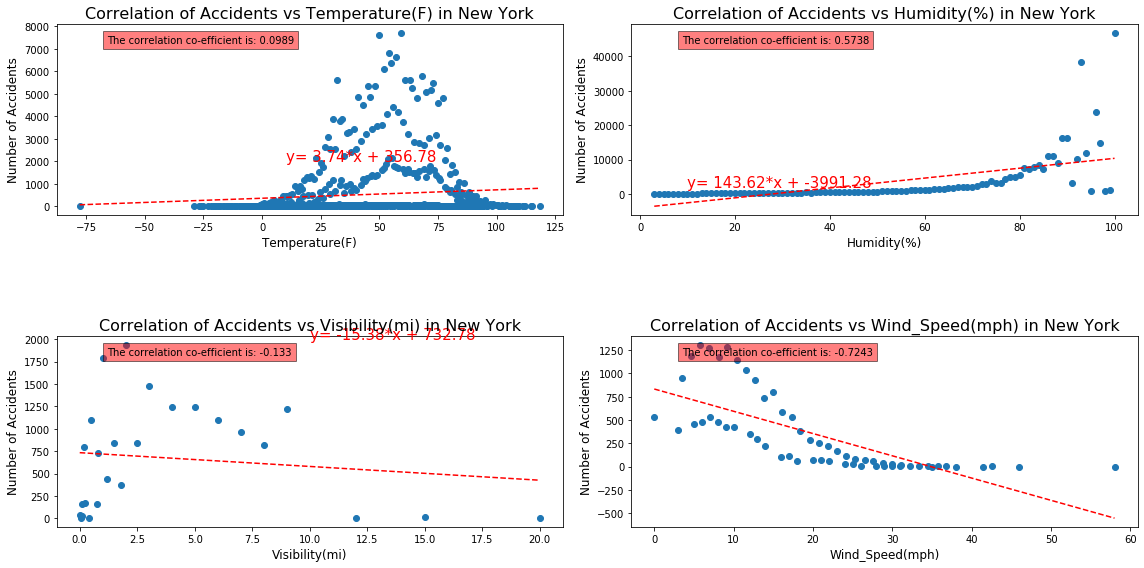

In [116]:
fig,ax =  plt.subplots(2,2,figsize=(16,8))
#fig=plt.figure(figsize=(20,8))

#multi_factor=["Humidity(%)","Visibility(mi)","Temperature(F)","Wind_Speed(mph)"]
#,"Precipitation(in)"
x_cord=0
y_cord=0

for factor in multi_factor:
    if factor=="Wind_Speed(mph)":
        accident_count_factor=accident_target_weather_related.loc[(accident_target_weather_related[factor]<=100) & (accident_target_weather_related["State"]=="NY")].groupby(factor).count().reset_index()
        x_axis=accident_count_factor[factor]
        y_axis=accident_count_factor["Start_Time"]
    elif factor=="Visibility(mi)":
        accident_count_factor=accident_target_weather_related.loc[(accident_target_weather_related[factor]!=10.0) & (accident_target_weather_related["State"]=="NY")].groupby(factor).count().reset_index()
        x_axis=accident_count_factor[factor]
        y_axis=accident_count_factor["Start_Time"]
    else:
        accident_count_factor=accident_target_weather_related.groupby(factor).count().reset_index()
        x_axis=accident_count_factor[factor]
        y_axis=accident_count_factor["Start_Time"]
    
    ax[x_cord][y_cord].scatter(x_axis,y_axis)
    
    ax[x_cord][y_cord].set_title(f"Correlation of Accidents vs {factor} in New York",fontsize=16)
    ax[x_cord][y_cord].set_xlabel(f"{factor}",fontsize=12)
    ax[x_cord][y_cord].set_ylabel("Number of Accidents",fontsize=12)

    #plt.yticks(np.arange(min(accident_count_factor["Start_Time"]),max(accident_count_factor["Start_Time"])+10000,10000))

    #plt.xticks(np.arange(min(accident_count_factor[factor]),max(accident_count_factor[factor])+5,10))

    slope,intercept,p,r,stderr=linregress(x_axis,y_axis)

    line_eq=f"y= {round(slope,2)}*x + {round(intercept,2)}"

    ax[x_cord][y_cord].plot(x_axis,((slope*x_axis)+intercept),"r--")
    
    corr,pvalue=pearsonr(accident_count_factor[factor],accident_count_factor["Start_Time"])

    ax[x_cord][y_cord].annotate(line_eq,(10,2000),color="red",fontsize=15)
    
    ax[x_cord][y_cord].text(0.1, 0.9,f"The correlation co-efficient is: {round(corr,4)}", transform=ax[x_cord][y_cord].transAxes,bbox=dict(facecolor='red', alpha=0.5))
    
    if(x_cord==0 and y_cord==0):
        y_cord=1
    elif (x_cord==0 and y_cord==1):
        x_cord=1
        y_cord=0
    elif (x_cord==1 and y_cord==0):
        y_cord=1
       
    plt.savefig("Images/Fig22. Accidents_vs_factors_ny")
    
    plt.tight_layout()


##### The relationship is in-line with US in general Except for visibility which shows a low relation wth the number of accidents.
##### The Visibility in New York is upto 20 mil compared to being 140 mil in US in general. The highest number of accidents fall in same range of first 10 miles in almost all of US.

### Correlation of temperature and visibility on Accident Count

In [117]:
accident_count_temp_visibility=pd.DataFrame(accident_target_weather_related[accident_target_weather_related["Visibility(mi)"]!=10]\
                                            .groupby(["Temperature(F)","Visibility(mi)"])["Start_Time"].count()).reset_index()
accident_count_temp_visibility.rename(columns={"Start_Time":"Accident Count"},inplace=True)
accident_count_temp_visibility["Combined Value"]=accident_count_temp_visibility["Temperature(F)"]\
*accident_count_temp_visibility["Visibility(mi)"]

accident_count_temp_visibility.head(200)


,Temperature(F),Visibility(mi),Accident Count,Combined Value
0,-29.0,6.0,2,-174.00
1,-27.0,4.0,1,-108.00
2,-26.0,4.0,2,-104.00
3,-26.0,5.0,2,-130.00
4,-26.0,6.0,3,-156.00
...,...,...,...,...
195,0.0,8.0,5,0.00
196,0.0,9.0,8,0.00
197,0.3,2.0,2,0.60
198,0.5,0.5,1,0.25


In [118]:
corr,pvalue=pearsonr(accident_count_temp_visibility["Combined Value"],accident_count_temp_visibility["Accident Count"])

print(f"The correlation co-efficient is: {corr}")

The correlation co-efficient is: 0.05938579728936091


##### The correlation co-efficient is very low when combining values of temperature and visibility and does not seem to correlate together with number of accidents

### Correlation of humidity and visibility on Accident Count

In [119]:
accident_count_humid_visibility=pd.DataFrame(accident_target_weather_related[accident_target_weather_related["Visibility(mi)"]!=10]\
                                            .groupby(["Humidity(%)","Visibility(mi)"])["Start_Time"].count()).reset_index()
accident_count_humid_visibility.rename(columns={"Start_Time":"Accident Count"},inplace=True)
accident_count_humid_visibility["Combined Value"]=accident_count_humid_visibility["Humidity(%)"]\
*accident_count_humid_visibility["Visibility(mi)"]

accident_count_humid_visibility.head(200)

,Humidity(%),Visibility(mi),Accident Count,Combined Value
0,4.0,1.0,4,4.0
1,4.0,1.5,2,6.0
2,4.0,3.0,1,12.0
3,4.0,4.0,7,16.0
4,5.0,4.0,4,20.0
...,...,...,...,...
195,23.0,1.0,1,23.0
196,23.0,1.2,1,27.6
197,23.0,1.8,2,41.4
198,23.0,2.0,7,46.0


In [120]:
corr,pvalue=pearsonr(accident_count_humid_visibility["Combined Value"],accident_count_humid_visibility["Accident Count"])

print(f"The correlation co-efficient is: {corr}")
    

The correlation co-efficient is: 0.0704428930379226


##### The correlation co-efficient is very low when combining values of humidity and visibility and does not seem to correlate together with number of accidents